# Agente Generador de Contexto

En este notebook, mediante el uso de la librería `Lang Graph`, se trabajará en la creación del grafo correspondiente al agente encargado de, mediante el uso de RAG, generar contexto relevante para los futuros agentes, como el creador de SQL y su posterior validador.


---

## Inicialización

### Librerías

In [1]:
import os
import sys
from dotenv import load_dotenv
from pathlib import Path
import json
from IPython.display import Markdown, Image

from collections import defaultdict
from typing import Annotated, Literal, Dict, TypedDict, List, Union, Optional, Any
import operator
from pydantic import BaseModel, Field, ValidationError


from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, ToolMessage, BaseMessage, SystemMessage
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.state import Send
from langgraph.checkpoint.memory import MemorySaver

from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from langchain.chains.sql_database.prompt import POSTGRES_PROMPT

from langchain.tools import tool, BaseTool
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent



# Añadimos el directorio raíz del proyecto al path
try:
    # Para scripts .py
    current_file = Path(__file__).resolve()
    project_root = current_file.parent.parent  # Ajusta si tu estructura cambia
except NameError:
    # Para notebooks
    current_file = Path().resolve()
    project_root = current_file.parent  # Ajusta según donde esté tu notebook

# Añadir al sys.path si no está ya
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from src.back.embeddings import GenAIExtendedEmbeddingFunction
from src.back.chroma_collections import (
    ContextEnricherChromaCollection,
    MdlHierarchicalChromaCollections,
    ExamplesChromaCollection
)




# import warnings
# warnings.filterwarnings('ignore')

### Constantes

In [2]:
TABLES_COLLECTION_NAME = 'mdl_tables_summary'
COLUMNS_COLLECTION_NAME = 'mdl_columns'
BUSINESS_LOGIC_COLLECTION_NAME = 'business_logic'
EXAMPLES_COLLECTION_NAME = 'query_examples'

GENAI_EMBEDDING_MODEL = 'gemini-embedding-001'

MAX_GENERATE_ITERATIONS = 3
MAX_CONTEXT_TOOL_CALLING = 3
MAX_SUBQUERIES_SPLIT = 5

### Modelos a utilizar

In [ ]:


llm_graders = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o-mini',
    temperature= 0,
    max_tokens= 1000
)

llm_classifiers = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o-mini',
    temperature= 0,
    max_tokens= 1000
)

llm_retrievals = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o-mini',
    temperature= 0,
    max_tokens= 1000
)

llm_generation = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4.1',
    temperature= 0,
    max_tokens= 2000
)

---

## Creación de Grafos

### Sub-grafo de Grader & Content Generation

#### LLM's

##### Retrieval Grader

In [4]:
class GradeRetrievalResult(BaseModel):
    """Boolean score for relevance check on retrieved documents."""

    relevant: bool = Field(
        description= "The document is relevant to the question, `true` or `false`"
    )

structured_llm_grader = llm_graders.with_structured_output(GradeRetrievalResult)


grade_system_prompt = """
You are a grader assessing the relevance of a retrieved document to a user's business question.

Your task is to compare the user's query against a given business context, which includes business \
rules and data schemas. The test for relevance is not stringent; its main purpose is to discard erroneous retrievals.

If at least one topic, keyword, or semantic concept from the user's question is found within the \
business context of the document, the document should be considered relevant.

Provide a binary result 'true' or 'false' to indicate whether the document is relevant.
"""

grade_prompt = ChatPromptTemplate.from_messages([
    ('system', grade_system_prompt),
    ('human', 'Retrieved document:\n{context}\n\nUser user_query:\n{user_query}'),
])

retrieval_grader = grade_prompt | structured_llm_grader

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

# doc_txt = ";\n\n    -- Ventas del 'Trimestre en Curso'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE) AND CURRENT_DATE;\n\n    -- Ventas del 'Trimestre Pasado'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';\n\n    -- Ventas del 'Primer semestre del año pasado'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE\n        order_date >= DATE_TRUNC('year', CURRENT_DATE - interval '1 year')\n        AND order_date < DATE_TRUNC('year', CURRENT_DATE - interval '1 year') + interval '6 months';;\n\n    -- Ventas del 'Semestre en Curso'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE\n        order_date >= (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) <= 6 THEN DATE_TRUNC('year', CURRENT_DATE)\n                ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months'\n            END\n        )\n        AND order_date < (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) > 6 THEN CURRENT_DATE\n                ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months'\n            END\n        );\n\n    -- Ventas del 'Semestre Pasado'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE\n        order_date >= (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) > 6 THEN DATE_TRUNC('year', CURRENT_DATE)\n                ELSE DATE_TRUNC('year', CURRENT_DATE - interval '1 year') + interval '6 months'\n            END\n        )\n        AND order_date < (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) <= 6 THEN DATE_TRUNC('year', CURRENT_DATE)\n                ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months'\n            END\n        );"


print(doc_txt)
print('-'*100 + '\n')

print('Relevant user_query:')
relevant_user_query = '¿Cuál es el promedio de ventas por producto?'
print(f"'{relevant_user_query}'")
print(retrieval_grader.invoke({"user_query": relevant_user_query, "context": doc_txt}))

print('\n' + '-'*100 + '\n')

print('Relevant user_query:')
relevant_user_query = 'Tell me the average value of sales by products.'
print(f"'{relevant_user_query}'")
print(retrieval_grader.invoke({"user_query": relevant_user_query, "context": doc_txt}))

print('\n' + '-'*100 + '\n')

print('No Relevant user_query:')
not_relevant_user_query = 'Dime el departamento con salario medio mayor'
print(f"'{not_relevant_user_query}'")
print(retrieval_grader.invoke({"user_query": not_relevant_user_query, "context": doc_txt}))


3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto

##### Generate

Diccionario de términos por tipo de consulta:

In [5]:
PROMPT_AJUSTMENT_DICT = {
    'business_logic': {
        'user_query': 'Business Rules related to: ',
        'output': (
            "Your final output should be a single, structured text that begins with the heading 'Synthesized Business Logic'. "
            "Start with a brief, high-level summary. "
            "Follow with a detailed breakdown of each business rule or concept from the context, using clear headings or bullet points. "
            "**Crucially, identify and extract any SQL expressions, code snippets, or fragments** that are used to define temporal calculations "
            "(e.g., 'mes pasado', 'Year to Date') or other business rules. **Include these exact SQL fragments directly within your detailed breakdown.**"
        )
    },
    'mdl': {
        'user_query': 'Tables summaries (including their keys) and columns needed to responds: ',
        'output': (
            "Your final output should be a single, structured text with two main sections:"
            "1. A detailed summary of all relevant **databases, schemas**, tables, and columns for the query."
            "2. A summary of how to relate these tables, with the option to propose **SQL join conditions** as fragments."
            "3. You are **ABSOLUTELY FORBIDDEN FROM INVENTING, EXTRACTING, OR SUGGESTING any new SQL query or complete SQL code** not "
            "provided in the source material. You may only provide relevant fragments or logical components of SQL that are directly "
            "derived from the table and join information provided in the context."
        )
    }
}

In [6]:
class GenerateContentResult(BaseModel):
    """Relevant content generated from bringed context based in user query."""

    generated_content: str = Field(
        description= "Brief content generated using bringed context."
    )

structured_llm_generator = llm_generation.with_structured_output(GenerateContentResult)


generate_system_prompt = """
You are an expert assistant designed to extract and summarize information from a given text. \
Your task is to analyze the retrieved context in the [CONTEXT] section \
and extract all information relevant to the user's query in [USER_QUERY].

---

### INSTRUCTIONS

1. Analyze the provided information contained within the [CONTEXT] section. \
    Your goal is to identify all topics, details, and **operational rules, definitions, or structural information** \
    that are related to the user's query or its language. This includes, but is not limited to, \
    business rules, logical definitions, data model structures, and data handling protocols.

2. Generate a comprehensive and detailed summary that includes **all** the relevant information found. \
    If the context contains rules on how to handle the query \
    (e.g., how to capture a product name, how to handle null values, specific business logic, or table relationships), \
    include these rules and details in your summary. The summary must be exhaustive, capturing key points \
    and significant details without adding external knowledge.

3. **Only if no information of any kind** (direct answer or operational rules/structures) is relevant to the user's query, \
    state clearly that the context does not contain relevant information.

4. Do not invent or assume information not explicitly present in the [CONTEXT] section. \
    If a specific data point is not mentioned, do not include it and do not comment on its absence.

5. Language: The output MUST be a text in **{language}**.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[CONTEXT]
<context>
{context}
</context>

---

### OUTPUT

{output_requirements}

Ensure every detail from the [CONTEXT] is accounted for and explained in a logical flow.
"""

generate_prompt = ChatPromptTemplate.from_template(generate_system_prompt)

generator = generate_prompt | structured_llm_generator

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

# doc_txt = '1. Representación de Entidades y Preferencias Lingüísticas\n\nCuando se solicita conceptualmente una entidad, como "productos", "clientes", "promociones" o "revendedores", se establece como principio operativo priorizar los campos que finalizan en `_name` para su adecuada representación en las salidas de las consultas SQL. Adicionalmente, se procurará mantener la coherencia con el idioma en que la consulta original fue formulada.\n\n- Principio Operativo: Para la visualización de entidades en los resultados de consultas, se debe seleccionar el campo `_name` que mejor represente la entidad. En el caso de campos bilingües donde la versión en español (`spanish_...name`, `spanish..._description`) pueda ser nula y la consulta se realice en español, se utilizará la versión en inglés como alternativa (`fallback`) para asegurar la disponibilidad del dato y mantener la representación de la entidad.\n- Lógica SQL (Ejemplo para `dim_product`):\n\n    ```sql\n    -- Selección del nombre del producto en español o, si es NULL, en inglés, para su representación\n    SELECT\n        product_key,\n        COALESCE(spanish_product_name, english_product_name) AS producto_nombre,\n        COALESCE(spanish_product_category_name, english_product_category_name) AS producto_category,\n        COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria\n    FROM\n        sales.dim_product;```\n\n    Este enfoque se aplicaría de manera similar a la representación de nombres de entidades en `dim_promotion`, `dim_customer`, `dim_reseller`, `dim_sales_person`, `dim_sales_reason`, `dim_sales_territory` y `dim_geography`, siempre privilegiando los campos `_name` relevantes y aplicando la lógica de `fallback` para el idioma.\n\nCuando se trata de campos como `product_line`, `class` y `style` de la  `dim_product`, los cuales pueden contener valores `NULL`, se establece como principio operativo completar los valores faltantes con una etiqueta que indique la ausencia de información, respetando el idioma de la consulta del usuario.\n\n- Principio Operativo: Para la visualización de atributos de productos que puedan ser nulos, se debe reemplazar el valor faltante por un placeholder que indique "no registrado", manteniendo la coherencia con el idioma de la consulta. Por ejemplo, se usará `\'|| No registrado ||\'` para consultas en español y `\'|| Not registered ||\'` para consultas en inglés.\n- Lógica SQL (Ejemplo para `dim_product`):\n\n    ```sql\n    -- Completar valores nulos en atributos de producto según el idioma de la consulta\n    SELECT\n        product_key,\n        COALESCE(product_line, \'|| No registrado ||\') AS producto_linea,\n        COALESCE(class, \'|| No registrado ||\') AS producto_clase,\n        COALESCE(style, \'|| No registrado ||\') AS producto_estilo\n    FROM\n        sales.dim_product;\n    ```'

doc_txt = ";\n\n    -- Ventas del 'Trimestre en Curso'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE) AND CURRENT_DATE;\n\n    -- Ventas del 'Trimestre Pasado'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';\n\n    -- Ventas del 'Primer semestre del año pasado'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE\n        order_date >= DATE_TRUNC('year', CURRENT_DATE - interval '1 year')\n        AND order_date < DATE_TRUNC('year', CURRENT_DATE - interval '1 year') + interval '6 months';;\n\n    -- Ventas del 'Semestre en Curso'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE\n        order_date >= (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) <= 6 THEN DATE_TRUNC('year', CURRENT_DATE)\n                ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months'\n            END\n        )\n        AND order_date < (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) > 6 THEN CURRENT_DATE\n                ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months'\n            END\n        );\n\n    -- Ventas del 'Semestre Pasado'\n    SELECT *\n    FROM sales.fact_sales\n    WHERE\n        order_date >= (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) > 6 THEN DATE_TRUNC('year', CURRENT_DATE)\n                ELSE DATE_TRUNC('year', CURRENT_DATE - interval '1 year') + interval '6 months'\n            END\n        )\n        AND order_date < (\n            CASE\n                WHEN EXTRACT(MONTH FROM CURRENT_DATE) <= 6 THEN DATE_TRUNC('year', CURRENT_DATE)\n                ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months'\n            END\n        );"


table_definition = {
        "table_summary": {
            "content": "Database: adventure_works_dw\nSchema: sales\nTable: fact_sales\nTable description: Tabla de hechos que contiene el detalle de las ordenes de ventas que ya han sido entregadas, con una granularidad a nivel de línea, mostrando siempre la última versión de cada pedido. SIEMPRE que se soliciten datos de ventas, como cantidades vendidas, importe de ventas, costes de ventas, impuestos, costes de envío, deberán ser obtenidos de esta tabla. Permite hacer desgloses a nivel de productos, clientes, tiendas/distribuidores, división territorial, promociones aplicadas y vendedores involucrados.\nTable PRIMARY KEY:\n- sales_order_number\n- sales_order_line_number\nTable FOREIGN KEYS (Column name, Reference):\n- (product_key, sales.dim_product.product_key)\n- (reseller_key, sales.dim_reseller.reseller_key)\n- (employee_key, sales.dim_sales_person.employee_key)\n- (customer_key, sales.dim_customer.customer_key)\n- (promotion_key, sales.dim_promotion.promotion_key)\n- (sales_territory_key, sales.dim_sales_territory.sales_territory_key)"
        },
        "columns": [
            {
                "content": "Column name: order_quantity\nColumn data type: INT2\nColumn description: Cantidad vendida de cada producto."
            },
            {
                "content": "Column name: unit_price\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de cada unidad de producto."
            },
            {
                "content": "Column name: extended_amount\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de todas las unidades de producto. Se calcula como `order_quantity * unit_price`."
            },
            {
                "content": "Column name: sale_source\nColumn data type: TEXT\nColumn description: Indicador de la fuente por la que ha sido realizado el pedido. 'reseller_sales'=Pedido realizado por un vendedor para una tienda/distribuidor, 'internet_sales'=Pedido realizado en línea por un cliente."
            },
            {
                "content": "Column name: order_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué creado."
            },
            {
                "content": "Column name: freight\nColumn data type: NUMERIC\nColumn description: Coste de envío en USD atribuíble a cada línea de orden de venta. Se reparte el total del coste de envío del pedido proporcionalmente al `sales_amount` de cada una de sus líneas."
            },
            {
                "content": "Column name: ship_date\nColumn data type: DATE\nColumn description: Fecha en la que se envió el pedido al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: sales_amount\nColumn data type: NUMERIC\nColumn description: Subtotal en USD de la línea de orden de venta. Se calcula como `extended_amount - discount_amount`."
            },
            {
                "content": "Column name: total_product_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de todas las unidades de producto. Se calcula como `order_quantity * product_standard_cost`."
            },
            {
                "content": "Column name: due_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué entregado al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: unit_price_discount_pct\nColumn data type: FLOAT8\nColumn description: Porcentaje de descuento aplicado sobre el precio unitario del producto. Está indicado en decimal, es decir, su rango va de 0 a 1."
            },
            {
                "content": "Column name: discount_amount\nColumn data type: FLOAT8\nColumn description: Importe total de descuento en USD. Se calcula como `extended_amount * unit_price_discount_pct`."
            },
            {
                "content": "Column name: tax_amt\nColumn data type: NUMERIC\nColumn description: Importe de impuestos en USD aplicable a la línea de orden de venta."
            },
            {
                "content": "Column name: product_standard_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de cada unidad de producto."
            }
        ]
    }
# doc_txt = json.dumps(table_definition, indent=2, ensure_ascii=False)

user_query = 'The product most selled in last quarter.'

entity = list(PROMPT_AJUSTMENT_DICT.keys())[0]
full_user_query = f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}".'
output_requirements = PROMPT_AJUSTMENT_DICT[entity]['output']

print("Retrieved context:\n{context}\n\nuser_query:\n{user_query}\n\nAnswer:".format(
    user_query= full_user_query, 
    context= doc_txt
))
print(generator.invoke({
    "user_query": full_user_query,
    "language": 'Spanish',
    "context": doc_txt,
    "output_requirements": output_requirements,
}).generated_content)

Retrieved context:
;

    -- Ventas del 'Trimestre en Curso'
    SELECT *
    FROM sales.fact_sales
    WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE) AND CURRENT_DATE;

    -- Ventas del 'Trimestre Pasado'
    SELECT *
    FROM sales.fact_sales
    WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';

    -- Ventas del 'Primer semestre del año pasado'
    SELECT *
    FROM sales.fact_sales
    WHERE
        order_date >= DATE_TRUNC('year', CURRENT_DATE - interval '1 year')
        AND order_date < DATE_TRUNC('year', CURRENT_DATE - interval '1 year') + interval '6 months';;

    -- Ventas del 'Semestre en Curso'
    SELECT *
    FROM sales.fact_sales
    WHERE
        order_date >= (
            CASE
                WHEN EXTRACT(MONTH FROM CURRENT_DATE) <= 6 THEN DATE_TRUNC('year', CURRENT_DATE)
                ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months'
            E

##### Halucionation Grader

In [7]:
class GradeHallucinationResult(BaseModel):
    """Boolean score for hallucination present in generation answer."""

    grounded: bool = Field(
        description= "Answer is grounded in the facts, `true` or `false`"
    )

structured_llm_hallucination = llm_graders.with_structured_output(GradeHallucinationResult)


hallucination_system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by the retrieved context.
ENSSURE THAT GENERATION MUST ONLY USE INFORMATION DIRECTLY FROM THE PROVIDED CONTEXT. \
Pay special attention to the names of fields and tables; the generation must use the exact names as they appear in the context. \
Any deviation, fabrication, or hallucination of field or table names will result in a 'false' score.
Give a binary result 'true' or 'false'. 'true' means that the answer is grounded in / supported by the set of facts.
"""

hallucination_prompt = ChatPromptTemplate.from_messages([
    ('system', hallucination_system_prompt),
    ('human', 'Set of facts:\n{context}\n\nLLM generation:\n{generation}'),
])

hallucination_grader = hallucination_prompt | structured_llm_hallucination

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

generation = """
In this context, the 'most sold' product is the one with the highest order_quantity (units sold). 
If you are evaluating by revenue, identify the product with the highest sales_amount ('de mayor facturación'). 
To determine the top-selling product, compare order_quantity across products; if revenue is the goal, compare sales_amount.
"""

generation = """The most selled products are those ones from the B2B segment."""

print('Set of facts:\n\n{context}\n\nLLM generation:\n{generation}'.format(
    generation= generation,
    context= doc_txt
))
print(hallucination_grader.invoke({"generation": generation, "context": doc_txt}))

Set of facts:


3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje 

##### Relevant Answer

In [8]:
class GradeAnswerResult(BaseModel):
    """Boolean score to assess answer addresses question."""

    addresses: bool = Field(
        description= "Answer addresses the question, `true` or `false`"
    )

structured_llm_answer_grader = llm_graders.with_structured_output(GradeAnswerResult)


answer_grade_system_prompt = """
You are a grader assessing whether a provided answer contains \
information relevant to a user's business question.

Your goal is not to check whether the answer fully solves the question, \
but whether it provides any partial contribution, hint, or useful detail \
that is related to the user's query.

The answer should be considered relevant if it:
- Mentions concepts, entities, or data sources related to the query.
- Provides a query, formula, rule, or business logic that could help address the question.
- Refers to the correct timeframe, metric, or domain, even if it does not directly provide the final result.

The answer should be considered irrelevant only if it contains no useful connection to the user's query.

Return strictly a binary result:
- true → if the answer contains any relevant information, even partial.
- false → if the answer is completely unrelated.
"""

answer_grade_prompt = ChatPromptTemplate.from_messages([
    ('system', answer_grade_system_prompt),
    ('human', 'User user_query:\n{user_query}\n\nLLM generation:\n{generation}'),
])

answer_grader = answer_grade_prompt | structured_llm_answer_grader

user_query = 'The product most selled in last quarter.'

generation = """
In this context, the 'most sold' product is the one with the highest order_quantity (units sold). 
If you are evaluating by revenue, identify the product with the highest sales_amount ('de mayor facturación'). 
To determine the top-selling product, compare order_quantity across products; if revenue is the goal, compare sales_amount.
"""

generation = """
To get the last quearter value for a single metric, you will use the next SQL:
SELECT * FROM sales WHERE order_date BETWEEN 2025-03-01 AND 2025-06-30
"""

print('user_query:\n{user_query}\n\nLLM generation:\n{generation}'.format(
    user_query= user_query,
    generation= generation
))
print(answer_grader.invoke({"user_query": user_query, "generation": generation}))

user_query:
The product most selled in last quarter.

LLM generation:

To get the last quearter value for a single metric, you will use the next SQL:
SELECT * FROM sales WHERE order_date BETWEEN 2025-03-01 AND 2025-06-30

addresses=True


#### Estado

In [9]:
class GradeGenerationState(TypedDict):
    user_query: str
    language: str
    entity: str
    context: str
    generate_iterations: int
    generation: List[str]

class GradeGenerationOutputState(TypedDict):
    generation: List[str]

#### Nodos

In [10]:
def generate_from_context(state: GradeGenerationState):
    """
    Generate relevant content for question based in context.

    Args:
        state (dict): The current graph state
    """
    print("---GENERATE---")
    user_query = state['user_query']
    language = state['language']
    entity = state.get('entity')
    context = state['context']
    generate_iterations = state.get('generate_iterations', 0)

    full_user_query = user_query
    output_requirements = ''
    if entity:
        full_user_query = (
            user_query
            if user_query.strip().upper().startswith(
                PROMPT_AJUSTMENT_DICT[entity]['user_query'].strip().upper()
            ) else
            f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}".'
        )

        output_requirements = PROMPT_AJUSTMENT_DICT[entity]['output']


    generation = generator.invoke({
        "language": language,
        "user_query": full_user_query,
        "context": context,
        "output_requirements": output_requirements,
    }).generated_content

    return {
        'generation': [generation],
        'generate_iterations': generate_iterations + 1
    }


def set_grade_output_ko(state: GradeGenerationState) -> dict[str, list]:
    print("---SET GRADE OUTPUT KO---")
    
    return {
        'generation': ['[NO RELEVANT CONTENT]']
    }

#### Conditional Edges

In [11]:
def grade_context(state: GradeGenerationState) -> Literal['generate', 'output_ko']:
    """
    Determines whether the retrieved document is relevant to the question.
    If it's, then proceed to generate content, else, go to end.

    Args:
        state: The current graph state

    Returns:
        Decision for next node to call
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    user_query = state['user_query']
    entity = state.get('entity')
    context = state['context']

    full_user_query = user_query
    if entity:
        full_user_query = (
            user_query
            if user_query.strip().upper().startswith(
                PROMPT_AJUSTMENT_DICT[entity]['user_query'].strip().upper()
            ) else
            f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}"'
        )
    
    relevant = retrieval_grader.invoke({'user_query': full_user_query, 'context': context}).relevant

    if relevant == True:
        print("---GRADE: DOCUMENT RELEVANT---")
        return 'generate'
    
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        return 'output_ko'



def grade_generation(state: GradeGenerationState) -> Literal['generate', 'output_ko', '__end__']:
    """
    Determines whether the generation is grounded in the 
    document and informative for question.

    Args:
        state (dict): The current graph state

    Returns:
        Decision for next node to call
    """
    print("---CHECK ITERATIONS---")
    generate_iterations = state['generate_iterations']

    if generate_iterations == MAX_GENERATE_ITERATIONS:
        return 'output_ko'


    print("---CHECK HALLUCINATIONS---")

    user_query = state['user_query']
    entity = state.get('entity')
    context = state['context']
    generation = state['generation'][0]

    grounded = hallucination_grader.invoke(
        {'context': context, 'generation': generation}
    ).grounded

    if grounded == True:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")


        full_user_query = user_query
        if entity:
            full_user_query = (
                user_query
                if user_query.strip().upper().startswith(
                    PROMPT_AJUSTMENT_DICT[entity]['user_query'].strip().upper()
                ) else
                f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}"'
            )
        addresses = answer_grader.invoke({
            'user_query': full_user_query,
            'generation': generation
        }).addresses

        if addresses == True:
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return '__end__'
        
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")

    return 'generate'

#### Grafo

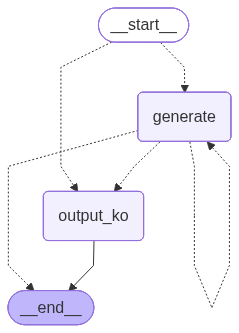

In [12]:
grading_generation_graph = StateGraph(
    state_schema= GradeGenerationState,
    input_schema= GradeGenerationState,
    output_schema= GradeGenerationOutputState
)

grading_generation_graph.add_node('generate', generate_from_context)
grading_generation_graph.add_node('output_ko', set_grade_output_ko)

grading_generation_graph.add_conditional_edges(
    START,
    grade_context
)
grading_generation_graph.add_conditional_edges(
    'generate',
    grade_generation
)
grading_generation_graph.add_edge('output_ko', END)


grading_generation_graph= grading_generation_graph.compile()

display(Image(grading_generation_graph.get_graph().draw_mermaid_png()))

In [13]:
doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

user_query = 'The name of the product most selled.'

grading_generation_graph.invoke({
    "user_query": user_query,
    "language": 'English',
    "entity": 'business_logic',
    "context": doc_txt, 
})

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---


{'generation': ['### Synthesized Business Logic\n\n#### High-Level Summary\nThe context provides metrics and definitions relevant to retail business analysis, including the interpretation of "most sold products" and other related metrics.\n\n#### Detailed Breakdown\n\n- **Definition of "Most Sold Products":**\n  - When referring to "most sold products," the metric used is the quantity of units sold (`order_quantity`).\n  - Alternatively, if the focus is on revenue, the metric is the sales amount (`sales_amount`). This distinction is explicitly stated when referring to "highest revenue-generating products."\n\n- **Additional Metrics for Analysis:**\n  - For profitability analysis, the key metrics are gross margin (`gross_margin`) and gross margin percentage (`gross_margin_percentage`).\n  - Promotional success is measured by the increase in `order_quantity` or `sales_amount` attributable to the promotion, alongside the overall profitability of the promotional period.\n\n- **Sales Channe

### Sub-grafo de Business Logic Retrieval

#### Tool

Definimos las la colección de Chroma que utilizaremos en nuestra tool:

In [14]:
genai_embeddings = GenAIExtendedEmbeddingFunction(model= GENAI_EMBEDDING_MODEL)
print(f'VertexAI: {genai_embeddings.genai_client._api_client.vertexai}')
print(f'Project: {genai_embeddings.genai_client._api_client.project}')
print(f'Location: {genai_embeddings.genai_client._api_client.location}')
print(f'Auth Tokens: {genai_embeddings.genai_client.auth_tokens}')


business_logic_collection = ContextEnricherChromaCollection(
    collection_name= BUSINESS_LOGIC_COLLECTION_NAME,
    embedding_function= genai_embeddings,
    host= os.getenv('CHROMA_SERVER_HOST'),
    port= os.getenv('CHROMA_LOCAL_PORT')
)

VertexAI: True
Project: gen-lang-client-0151767776
Location: europe-west1
Auth Tokens: <google.genai.tokens.Tokens object at 0x0000021ECA84D010>


Definimos el esquema que deberá utilizar el LLM para llamar a la tool:

In [15]:
class RetrieverInput(BaseModel):
    """
    Input schema for retriever tools. Accepts one or more queries for retrieval.
    """
    queries: List[str] = Field(
        description= (
            "A list of one or more search queries to retrieve relevant information. "
            f"Break down the user's question into up to {MAX_SUBQUERIES_SPLIT} simple, focused sub-queries to maximize retrieval accuracy. "
            "Each sub-query should represent a key concept from the original question."
        )
    )

Procedemos a crear la tool que nos permitirá hacer retrival de los documentos de lógica de negocio relevantes para la consulta del usuario:

In [16]:
@tool("business_logic_retriever", args_schema=RetrieverInput)
def get_business_logic(queries: List[str]) -> List[str]:
    """
    Retrieve detailed business logic, including KPI calculations, domain-specific rules, and definitions of business concepts.
    This is the primary source for understanding the semantic meaning and 'why' behind the data. 
    Provide multiple queries to cover all relevant business aspects.
    """

    search_results = business_logic_collection.enriched_context_search(
        queries= queries,
        context_window_size= 3,
        merge_results= True,
        search_type= 'mmr',
        k= 10,
        fetch_k= 25,
        lambda_mult= 0.5
    )

    if not search_results:
        return ['No semantically relevant results were found for the specified queries.']

    return search_results

#### LLM's

##### Business Logic Retriever

Usamos el esquema definido para el input de las tools de retrieval como esquema de salida de este agente.

In [17]:
business_logic_retrieval_prompt = """
You are an AI agent tasked with retrieving semantically \
relevant business logic from a vector database.

Your sole function is to decompose the user's original query into a \
maximum of {max_queries} semantically distinct sub-queries. The decomposition \
should aim to capture every possible analytical facet of the original query, including, but not limited to:
- **Time Intelligence:** Specific timeframes, periods, and temporal relationships.
- **Business Metrics:** Key performance indicators (KPIs), measures, and relevant figures.
- **Calculation Rules:** Formulas, aggregation methods, and computational logic.
- **Naming Conventions:** Aliases, synonyms, and specific terminology.
- **Null Treatments:** Handling of missing or null values.
- **Data Granularity:** The level of detail required for the analysis.
"""

business_logic_prompt = ChatPromptTemplate.from_messages([
    ('system', business_logic_retrieval_prompt),
    ('human', 'User user_query:\n{user_query}'),
])


structured_llm_business_logic_retriever = llm_retrievals.with_structured_output(RetrieverInput)

retrieval_business_logic = business_logic_prompt | structured_llm_business_logic_retriever

user_query = '¿Cuál es el promedio de ventas por producto?'
retrieval_business_logic.invoke({'max_queries': MAX_SUBQUERIES_SPLIT, 'user_query': user_query}).queries

['¿Cuál es el promedio de ventas por producto en el último año?',
 '¿Qué métricas se utilizan para calcular el promedio de ventas por producto?',
 '¿Cómo se manejan los valores nulos en el cálculo del promedio de ventas?',
 '¿Qué nivel de detalle se requiere para analizar las ventas por producto?',
 '¿Existen convenciones de nombres específicas para los productos en los datos de ventas?']

##### Business Logic Summarizer

Usamos el esquema asociado a generadores creado en la sección anterior.

In [18]:
class BusinessLogicSummaryResult(BaseModel):
    """Relevant summary generated from document retrival based in user query."""

    generated_summary: str = Field(
        description= "Summary of the relevant content in business logic chunks retrieval."
    )

structured_llm_business_logic_summarizer = llm_generation.with_structured_output(BusinessLogicSummaryResult)


business_logic_summarizer_system_prompt = """
You're a highly precise and diligent Business Logic Synthesis Agent. \
Your sole purpose is to process and synthesize complex business logic information \
provided as context for a given user query. Your goal is to produce a single, \
comprehensive, and detailed output that consolidates all the provided information.

---

### INSTRUCTIONS

1. Strictly Adhere to Context: Your response must be derived exclusively from the \
    information contained within the [CONTEXT] section. You MUST NOT invent, infer, \
    or hallucinate any details, rules, or logic that are not explicitly present in the provided extracts.

2. Handle Lack of Context: If a context extract explicitly states that no relevant information \
    is available for a specific topic, you must ignore that extract. \
    If all provided context extracts state that no relevant information is available, \
    your final output must be a single, brief sentence stating that no relevant business \
    logic was found for the user's query.

3. Ensure Full Coverage: Every single piece of information, every rule, and every topic \
    mentioned in the [CONTEXT] must be incorporated into your final output. \
    Leave no topic unaddressed.

4.  **SQL Handling:** You MUST INCLUDE any SQL fragments or clauses that are \
    explicitly present in the [CONTEXT]. You are FORBIDDEN from inventing, extracting, \
    or suggesting any new SQL code not provided in the source material. You may only \
    provide relevant fragments or logical components of SQL that are directly derived \
    from the business logic provided in the context.

5.  **Time-Based Logic:** If the user query involves temporal filtering or aggregation \
    (e.g., "last month," "Year-To-Date," "YTD"), you MUST specifically capture the business \
    rules that define this time-based logic. This is crucial for the data analyst to be able \
    to apply the correct filters. **If the context provides SQL fragments related to these \
    temporal concepts, you MUST include them as examples and reference points, ensuring the \
    analyst has all the necessary information to replicate the logic.**

6. Field Names & Rules: **You must not modify the names of fields, columns, or rules**. \
    Only allow adjustments for clarity, linguistic translation, or aliasing if needed to make the output \
    understandable. The underlying logic, names, and references must remain identical to the context.

7. No Full Queries: **Do not generate full or executable SQL queries**. Only provide fragments or \
    components strictly derived from the context, adjusted for clarity if necessary, without changing the underlying logic.

8.  **Language & Adaptation:** The output MUST be a text in **{language}**. \
    If the context provides language-specific information (e.g., placeholder values or SQL fragments) \
    that do not match the {language} of the user's query, you MUST translate or adapt this information \
    to the target language. For example, if the query is in English and a rule mentions a placeholder \
    "No registrado," you should adapt it to a relevant English equivalent like "Not Registered."

9. Purpose-Oriented Output: The final output is intended for a data analyst who will use \
    it to build a structured SQL query. Therefore, the response must be clear, precise, \
    and contain all the necessary details to represent the business rules accurately. \
    Organize the information logically using headings, subheadings, and bullet points to \
    facilitate easy understanding and translation into a query structure.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[CONTEXT]
<context>
{context}
</context>

---

### OUTPUT
Your final output should be a single, structured text that begins with the heading \
"Synthesized Business Logic". Start with a brief, high-level summary. \
Follow with a detailed breakdown of each business rule or concept from the context, \
using clear headings or bullet points.

Ensure every detail from the [CONTEXT] is accounted for and explained in a logical flow.
"""

business_logic_summary_prompt = ChatPromptTemplate.from_template(
    business_logic_summarizer_system_prompt
)

business_logic_summarizer = business_logic_summary_prompt | structured_llm_business_logic_summarizer

doc_txt = [
    """
    3. Métricas Clásicas del Retail y su Interpretación

    Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
    - Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
    - Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
    - En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
    - Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
    - Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
    """,
    """
    1. Representación de Entidades y Preferencias Lingüísticas

    Cuando se solicita conceptualmente una entidad, como "productos", "clientes", "promociones" o "revendedores", se establece como principio operativo priorizar los campos que finalizan en `_name` para su adecuada representación en las salidas de las consultas SQL. Adicionalmente, se procurará mantener la coherencia con el idioma en que la consulta original fue formulada.

    - Principio Operativo: Para la visualización de entidades en los resultados de consultas, se debe seleccionar el campo `_name` que mejor represente la entidad. En el caso de campos bilingües donde la versión en español (`spanish_...name`, `spanish..._description`) pueda ser nula y la consulta se realice en español, se utilizará la versión en inglés como alternativa (`fallback`) para asegurar la disponibilidad del dato y mantener la representación de la entidad.
    - Lógica SQL (Ejemplo para `dim_product`):

        ```sql
        -- Selección del nombre del producto en español o, si es NULL, en inglés, para su representación
        SELECT
            product_key,
            COALESCE(spanish_product_name, english_product_name) AS producto_nombre,
            COALESCE(spanish_product_category_name, english_product_category_name) AS producto_category,
            COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria
        FROM
            sales.dim_product;```

        Este enfoque se aplicaría de manera similar a la representación de nombres de entidades en `dim_promotion`, `dim_customer`, `dim_reseller`, `dim_sales_person`, `dim_sales_reason`, `dim_sales_territory` y `dim_geography`, siempre privilegiando los campos `_name` relevantes y aplicando la lógica de `fallback` para el idioma.

    Cuando se trata de campos como `product_line`, `class` y `style` de la  `dim_product`, los cuales pueden contener valores `NULL`, se establece como principio operativo completar los valores faltantes con una etiqueta que indique la ausencia de información, respetando el idioma de la consulta del usuario.

    - Principio Operativo: Para la visualización de atributos de productos que puedan ser nulos, se debe reemplazar el valor faltante por un placeholder que indique "no registrado", manteniendo la coherencia con el idioma de la consulta. Por ejemplo, se usará `'|| No registrado ||'` para consultas en español y `'|| Not registered ||'` para consultas en inglés.
    - Lógica SQL (Ejemplo para `dim_product`):

        ```sql
        -- Completar valores nulos en atributos de producto según el idioma de la consulta
        SELECT
            product_key,
            COALESCE(product_line, '|| No registrado ||') AS producto_linea,
            COALESCE(class, '|| No registrado ||') AS producto_clase,
            COALESCE(style, '|| No registrado ||') AS producto_estilo
        FROM
            sales.dim_product;
        ```
    """
]

doc_txt = """
### Lógica de Negocio Sintetizada

#### Resumen General
El contexto proporciona consultas SQL que definen períodos temporales específicos para analizar datos de ventas. Estas consultas se centran en trimestres y semestres actuales y pasados, así como en el primer semestre del año anterior.

#### Detalles Específicos

1. **Ventas del Trimestre en Curso**:
   - Consulta: `SELECT * FROM sales.fact_sales WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE) AND CURRENT_DATE;`
   - Filtra las ventas desde el inicio del trimestre actual hasta la fecha actual.

2. **Ventas del Trimestre Pasado**:
   - Consulta: `SELECT * FROM sales.fact_sales WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';`
   - Filtra las ventas del trimestre anterior.

3. **Ventas del Primer Semestre del Año Pasado**:
   - Consulta: `SELECT * FROM sales.fact_sales WHERE order_date >= DATE_TRUNC('year', CURRENT_DATE - interval '1 year') AND order_date < DATE_TRUNC('year', CURRENT_DATE - interval '1 year') + interval '6 months';`
   - Filtra las ventas del primer semestre del año anterior.

4. **Ventas del Semestre en Curso**:
   - Consulta: `SELECT * FROM sales.fact_sales WHERE order_date >= (CASE WHEN EXTRACT(MONTH FROM CURRENT_DATE) <= 6 THEN DATE_TRUNC('year', CURRENT_DATE) ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months' END) AND order_date < (CASE WHEN EXTRACT(MONTH FROM CURRENT_DATE) > 6 THEN CURRENT_DATE ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months' END);`
   - Filtra las ventas del semestre actual.

5. **Ventas del Semestre Pasado**:
   - Consulta: `SELECT * FROM sales.fact_sales WHERE order_date >= (CASE WHEN EXTRACT(MONTH FROM CURRENT_DATE) > 6 THEN DATE_TRUNC('year', CURRENT_DATE) ELSE DATE_TRUNC('year', CURRENT_DATE - interval '1 year') + interval '6 months' END) AND order_date < (CASE WHEN EXTRACT(MONTH FROM CURRENT_DATE) <= 6 THEN DATE_TRUNC('year', CURRENT_DATE) ELSE DATE_TRUNC('year', CURRENT_DATE) + interval '6 months' END);`
   - Filtra las ventas del semestre anterior.

#### Observación
El contexto no incluye reglas específicas para determinar "el producto más vendido en el último trimestre". Sin embargo, las consultas proporcionadas pueden ser utilizadas como base para calcular este dato mediante agregaciones adicionales en SQL.
"""

user_query = 'The product most selled in the last quearter.'

context = '\n\n---\n\n'.join(doc_txt)

print(business_logic_summarizer.invoke({
    "user_query": user_query,
    "language": 'English',
    "context": context
}).generated_summary)

Synthesized Business Logic

Summary:
The context provides SQL queries and temporal filtering logic for analyzing sales data over specific periods, including quarters and semesters. However, it does not include specific rules for determining the most sold product in the last quarter.

Details:
1. **Sales Data for Current Quarter:**
   - SQL Query: `SELECT * FROM sales.fact_sales WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE) AND CURRENT_DATE;`
   - Filters sales from the start of the current quarter to the current date.

2. **Sales Data for Previous Quarter:**
   - SQL Query: `SELECT * FROM sales.fact_sales WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';`
   - Filters sales from the previous quarter.

3. **Sales Data for First Semester of Previous Year:**
   - SQL Query: `SELECT * FROM sales.fact_sales WHERE order_date >= DATE_TRUNC('year', CURRENT_DATE - interval '1 year') AND o

#### Estado

In [19]:
class BusinessLogicState(TypedDict):
    user_query: str
    language: str
    entity: str
    sub_queries: List[str]
    retieval_iterations: int
    retrieval_results: List[str]
    business_logic_retrieval_results: List[str]
    generation: Annotated[List[str], operator.add]
    business_logic: str

class BusinessLogicOutputState(TypedDict):
    business_logic_retrieval_results: List[str]
    business_logic: str

#### Nodos

In [ ]:
def generate_business_logic_sub_queries(state: BusinessLogicState):
    """
    Create relevant sub-queries for the user question to improve retrieval.

    Args:
        state (dict): The current graph state
    """
    print("---BUSINESS LOGIC SUB-QUERIES---")
    user_query = state['user_query']
    entity = state.get('entity', 'business_logic')
    retieval_iterations = state.get('retieval_iterations', 0)
    
    sub_queries = retrieval_business_logic.invoke({
            'max_queries': MAX_SUBQUERIES_SPLIT,
            'user_query': user_query
    }).queries

    return {
        'entity': entity,
        'sub_queries': sub_queries,
        'retieval_iterations': retieval_iterations + 1,
    }


def retrieve_business_logic_queries(state: BusinessLogicState):
    """
    Execute tool to retrieve business logic results.

    Args:
        state (dict): The current graph state
    """
    print("---BUSINESS LOGIC RETRIEVE TOOL---")
    queries = state['sub_queries']
    
    retrieval_results = get_business_logic.invoke(input= {'queries': queries})

    return {
        'retrieval_results': retrieval_results,
        'business_logic_retrieval_results': retrieval_results
    }


def summarize_business_logic(state: BusinessLogicState):
    """
    Consolidate business logic context summaries.

    Args:
        state (dict): The current graph state
    """
    print("---BUSINES LOGIC SUMMARIZING---")
    
    user_query = state['user_query']
    language = state["language"]
    generation = [
        generation_result 
        for generation_result in state['generation']
        if generation_result != '[NO RELEVANT CONTENT]'
    ]

    if not generation:
        return {
            'business_logic': 'Business logic for this request was not found. Please try a different query.'
        }


    context = '\n\n---\n\n'.join(generation)

    business_logic_summary = business_logic_summarizer.invoke({
        "user_query": user_query, 
        "language": language,
        "context": context
    }).generated_summary

    return {
        'business_logic': business_logic_summary
    }


#### Conditional Edges

In [ ]:
def send_to_parallel_grade(state):
    """
    Conditional edge to reach generation parallelization.

    Args:
        state (dict): The current graph state
    """
    print("---PARALLELIZE GENERATION---")

    user_query = state['user_query']
    language = state['language']
    entity = state['entity']
    retrieval_results = state['retrieval_results']

    return [
        Send('grade_retrieval', {
            'user_query': user_query,
            'language': language,
            'context': context,
            'entity': entity
        })
        for context in retrieval_results
    ]


#### Grafo

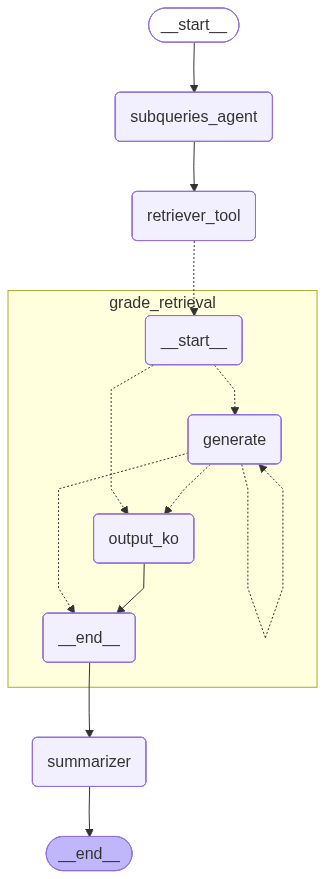

In [ ]:
business_logic_graph = StateGraph(
    state_schema= BusinessLogicState,
    input_schema= BusinessLogicState,
    output_schema= BusinessLogicOutputState
)

business_logic_graph.add_node('subqueries_agent', generate_business_logic_sub_queries)
business_logic_graph.add_node('retriever_tool', retrieve_business_logic_queries)
business_logic_graph.add_node('grade_retrieval', grading_generation_graph)
business_logic_graph.add_node('summarizer', summarize_business_logic)

business_logic_graph.add_edge(START, 'subqueries_agent')
business_logic_graph.add_edge('subqueries_agent', 'retriever_tool')
business_logic_graph.add_conditional_edges('retriever_tool', send_to_parallel_grade, ['grade_retrieval'])
business_logic_graph.add_edge('grade_retrieval', 'summarizer')
business_logic_graph.add_edge('summarizer', END)


business_logic_graph = business_logic_graph.compile()

display(Image(business_logic_graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
user_query = 'The name of the product with highest sales in last quarter.'

business_logic_test = business_logic_graph.invoke({
    "user_query": user_query,
    'language': 'English'
})['business_logic']

Markdown(business_logic_test)

---BUSINESS LOGIC SUB-QUERIES---
---BUSINESS LOGIC RETRIEVE TOOL---
---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
-

Synthesized Business Logic

### High-Level Summary
The context provides SQL logic and definitions for calculating sales data over various temporal periods, such as quarters, semesters, and year-to-date metrics. It emphasizes the use of the `order_date` field from the `fact_sales` table for these calculations.

### Detailed Breakdown

#### Temporal Period Definitions
- **Quarter**: A three-month period, with four quarters in a year (Q1: Jan-Mar, Q2: Apr-Jun, Q3: Jul-Sep, Q4: Oct-Dec).
- **Semester**: A six-month period, with two semesters in a year (H1: Jan-Jun, H2: Jul-Dec).

#### SQL Logic for Temporal Calculations
- **Last Quarter Sales**:
  ```sql
  SELECT *
  FROM sales.fact_sales
  WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';
  ```

#### Specific Query Analysis
The user's query pertains to identifying the product with the highest sales in the last quarter. While the context provides SQL logic for calculating sales data for the last quarter, it does not explicitly include logic for determining the product with the highest sales. However, the following SQL snippet can be adapted:

```sql
SELECT product_key, SUM(sales_amount) AS total_sales
FROM sales.fact_sales
WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day'
GROUP BY product_key
ORDER BY total_sales DESC
LIMIT 1;
```

This query calculates the total sales for each product in the last quarter, orders the results by sales amount in descending order, and retrieves the product with the highest sales.

### Sub-grafo de MDL Model Retrieval

#### Tool

Definimos la colección de Chroma que utilizaremos en nuestra tool:

In [49]:
genai_embeddings = GenAIExtendedEmbeddingFunction(model= GENAI_EMBEDDING_MODEL)
print(f'VertexAI: {genai_embeddings.genai_client._api_client.vertexai}')
print(f'Project: {genai_embeddings.genai_client._api_client.project}')
print(f'Location: {genai_embeddings.genai_client._api_client.location}')
print(f'Auth Tokens: {genai_embeddings.genai_client.auth_tokens}')

mdl_collection = MdlHierarchicalChromaCollections(
    collection_names= (TABLES_COLLECTION_NAME, COLUMNS_COLLECTION_NAME),
    embedding_function= genai_embeddings,
    host= os.getenv('CHROMA_SERVER_HOST', 'localhost'),
    port= os.getenv('CHROMA_LOCAL_PORT', '8000')
)

VertexAI: True
Project: gen-lang-client-0151767776
Location: europe-west1
Auth Tokens: <google.genai.tokens.Tokens object at 0x0000021ECFFAA9D0>


Utilizaremos la clase ya creada en la sección anterior.

Procedemos a crear la tool que nos permitirá hacer retrival de los documentos de lógica de negocio relevantes para la consulta del usuario:

In [50]:
@tool("mdl_data_retriever", args_schema=RetrieverInput)
def get_mdl_data(queries: List[str]) -> List[Dict[str, str]]:
    """
    Retrieve table schemas, column definitions, primary and foreign keys. 
    This tool is essential for identifying the specific tables and columns required to construct a valid SQL query. 
    It provides the 'what' and 'where' of the data.
    """

    search_results = mdl_collection.hierarchical_similarity_search(
        queries= queries,
        merge_results= True,
        show_relevance_score= False,
        k_tables= 10,
        tables_score_threshold= 0.75,
        k_columns= 15,
        columns_score_threshold= 0.75
    )

    if not search_results:
        return 'No semantically relevant results were found for the specified queries.'

    return search_results

#### LLM's

##### MDL Model Retriever

Utilizamos el esquema definido junto a la tool.

In [51]:
mdl_retrieval_prompt = """
You are an AI agent tasked with retrieving semantically \
relevant tables summaries and columns details from a vector database.

Your sole function is to decompose the user's original query into a maximum \
of {max_queries} semantically distinct sub-queries.
"""

mdl_prompt = ChatPromptTemplate.from_messages([
    ('system', mdl_retrieval_prompt),
    ('human', 'User user_query:\n{user_query}'),
])


structured_llm_mdl_retriever = llm_retrievals.with_structured_output(RetrieverInput)

retrieval_mdl = mdl_prompt | structured_llm_mdl_retriever

user_query = '¿Cuál es el promedio de ventas por producto?'
retrieval_mdl.invoke({'max_queries': MAX_SUBQUERIES_SPLIT, 'user_query': user_query}).queries

['promedio de ventas por producto',
 'ventas por producto',
 'análisis de ventas por producto',
 'estadísticas de ventas por producto',
 'información sobre ventas promedio']

##### MDL Model Summarizer

In [52]:
class MdlModelSummaryResult(BaseModel):
    """Relevant summary generated from document retrival based in user query."""

    generated_summary: str = Field(
        description= "Summary of the relevant content in tables summaries and columns details retrieval."
    )

structured_llm_mdl_summarizer = llm_generation.with_structured_output(MdlModelSummaryResult)


mdl_summarizer_system_prompt = """
You're a highly precise and diligent Data Schema Synthesis Agent. \
Your sole purpose is to process and synthesize complex data schema information \
about database tables and columns provided as context for a given user query. \
Your goal is to produce a single, comprehensive, and detailed output \
that consolidates all the provided information, **including whether a column can have null values.**

---

### INSTRUCTIONS

1. Strictly Adhere to Context: Your response must be derived exclusively from the \
    information contained within the [CONTEXT] section. You MUST NOT invent, infer, \
    or hallucinate any details, tables, or columns that are not explicitly present \
    in the provided context. **This includes all column attributes, such as data type, \
    primary key status, and nullability (whether it can contain NULL values), \
    and the specific database and schema where the table or column is located.**

2. Handle Lack of Context: If a context extract explicitly states that no relevant information \
    is available, you must ignore that extract. If all provided context extracts state that no \
    relevant information is available, your final output must be a single, brief sentence stating \
    that no relevant tables or columns were found for the user's query.

3. Ensure Full Coverage: Every single piece of relevant information, every relevant table description, \
    and every relevant column mentioned in the [CONTEXT] must be incorporated into your final output. \
    Leave no detail unaddressed. **This includes reporting on all available column properties, \
    especially whether a column can be NULL, and its database and schema.**

4. Prioritize Inclusion: You **MUST** prioritize providing all columns that are potentially relevant, \
    including similar columns (e.g., in different languages) over the risk of omitting valuable information. \
    The relevance of a column is determined by its name and description, not by the language of the user's query.

5. SQL Handling: You **MUST INCLUDE** any SQL fragments or clauses that are **explicitly present** in the [CONTEXT]. \
    You are **ABSOLUTELY FORBIDDEN FROM INVENTING, EXTRACTING, OR SUGGESTING any new SQL query or complete SQL code** not \
    provided in the source material. You may only provide relevant fragments or logical components of SQL that are directly \
    derived from the table and join information provided in the context.

6. Column Names: **You must never modify the names of columns**. The only permissible changes are for \
    aliasing in the final output for clarity or linguistic adjustment. All column names must match exactly \
    those present in the [CONTEXT].

7. No Full Queries: **Do not generate full or executable SQL queries**. Only provide fragments or components \
    strictly derived from the context, adjusted for clarity if necessary, without changing the underlying logic.

8. Language: The output MUST be a text in **{language}**.

9. Purpose-Oriented Output: The final output is intended for a data analyst who will use \
    it to build a structured SQL query. Therefore, the response must be clear, precise, \
    and contain all the necessary details to represent the table structure and relationships accurately. \
    Organize the information logically using markdown headings, subheadings, and bullet points to \
    facilitate easy understanding and translation into a query structure.

---

### INPUT

[USER_QUERY]
<user_quer>
{user_query}
</user_quer>

[CONTEXT]
<context>
{context}
</context>

---

### OUTPUT
Your final output should be a single, structured text with two main sections:
1. A detailed summary of all relevant tables and columns for the query, \
    making sure to specify if each column can be NULL, **as well as the database and schema it belongs to**.
2. A summary of how to relate these tables, with the option to propose **SQL join conditions** as fragments.

Ensure every detail from the [CONTEXT] is accounted for and explained in a logical flow.
"""

mdl_summary_prompt = ChatPromptTemplate.from_template(
    mdl_summarizer_system_prompt
)

mdl_summarizer = mdl_summary_prompt | structured_llm_mdl_summarizer

doc_txt = [
    {
        "table_summary": {
            "content": "Database: adventure_works_dw\nSchema: sales\nTable: fact_sales\nTable description:  de hechos que contiene el detalle de las ordenes de ventas que ya han sido entregadas, con una granularidad a nivel de línea, mostrando siempre la última versión de cada pedido. SIEMPRE que se soliciten datos de ventas, como cantidades vendidas, importe de ventas, costes de ventas, impuestos, costes de envío, deberán ser obtenidos de esta . Permite hacer desgloses a nivel de productos, clientes, tiendas/distribuidores, división territorial, promociones aplicadas y vendedores involucrados.\nTable PRIMARY KEY:\n- sales_order_number\n- sales_order_line_number\nTable FOREIGN KEYS (Column name, Reference):\n- (product_key, sales.dim_product.product_key)\n- (reseller_key, sales.dim_reseller.reseller_key)\n- (employee_key, sales.dim_sales_person.employee_key)\n- (customer_key, sales.dim_customer.customer_key)\n- (promotion_key, sales.dim_promotion.promotion_key)\n- (sales_territory_key, sales.dim_sales_territory.sales_territory_key)"
        },
        "columns": [
            {
                "content": "Column name: order_quantity\nColumn data type: INT2\nColumn description: Cantidad vendida de cada producto."
            },
            {
                "content": "Column name: unit_price\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de cada unidad de producto."
            },
            {
                "content": "Column name: extended_amount\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de todas las unidades de producto. Se calcula como `order_quantity * unit_price`."
            },
            {
                "content": "Column name: sale_source\nColumn data type: TEXT\nColumn description: Indicador de la fuente por la que ha sido realizado el pedido. 'reseller_sales'=Pedido realizado por un vendedor para una tienda/distribuidor, 'internet_sales'=Pedido realizado en línea por un cliente."
            },
            {
                "content": "Column name: order_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué creado."
            },
            {
                "content": "Column name: freight\nColumn data type: NUMERIC\nColumn description: Coste de envío en USD atribuíble a cada línea de orden de venta. Se reparte el total del coste de envío del pedido proporcionalmente al `sales_amount` de cada una de sus líneas."
            },
            {
                "content": "Column name: ship_date\nColumn data type: DATE\nColumn description: Fecha en la que se envió el pedido al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: sales_amount\nColumn data type: NUMERIC\nColumn description: Subtotal en USD de la línea de orden de venta. Se calcula como `extended_amount - discount_amount`."
            },
            {
                "content": "Column name: total_product_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de todas las unidades de producto. Se calcula como `order_quantity * product_standard_cost`."
            },
            {
                "content": "Column name: due_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué entregado al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: unit_price_discount_pct\nColumn data type: FLOAT8\nColumn description: Porcentaje de descuento aplicado sobre el precio unitario del producto. Está indicado en decimal, es decir, su rango va de 0 a 1."
            },
            {
                "content": "Column name: discount_amount\nColumn data type: FLOAT8\nColumn description: Importe total de descuento en USD. Se calcula como `extended_amount * unit_price_discount_pct`."
            },
            {
                "content": "Column name: tax_amt\nColumn data type: NUMERIC\nColumn description: Importe de impuestos en USD aplicable a la línea de orden de venta."
            },
            {
                "content": "Column name: product_standard_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de cada unidad de producto."
            }
        ]
    },
    {
        "table_summary": {
            "content": "Database: adventure_works_dw\nSchema: sales\nTable: dim_product\nTable description:  de dimensión que almacena la información detallada de cada producto que alguna vez haya sido vendido. Relevante para cualquier consulta en la que se nos pida listar productos por su nombre.\nTable PRIMARY KEY:\n- product_key"
        },
        "columns": [
            {
                "content": "Column name: list_price\nColumn data type: NUMERIC\nColumn description: Precio de venta del producto en USD."
            },
            {
                "content": "Column name: active\nColumn data type: BOOL\nColumn description: Indicador de si el producto sigue disponible para la venta."
            },
            {
                "content": "Column name: finished_goods_flag\nColumn data type: BOOL\nColumn description: Indicador de si se trata de un producto final vendible. '0'=El producto no es un artículo vendible, '1'=El producto es vendible."
            },
            {
                "content": "Column name: spanish_product_category_name\nColumn data type: VARCHAR(50)\nColumn description: Categoría principal a la que pertenece el producto (ESPAÑOL). Las categorías son 'Prenda', 'Componente', 'Accesorio' y 'Bicicleta'  NUNCA viene a NULL."
            },
            {
                "content": "Column name: english_product_category_name\nColumn data type: VARCHAR(50)\nColumn description: Categoría principal a la que pertenece el producto (INGLÉS). Las categorías son 'Clothing', 'Components', 'Accessories' y 'Bikes'. NUNCA viene a NULL."
            },
            {
                "content": "Column name: style\nColumn data type: BPCHAR(2)\nColumn description: Público para el que está pensado el producto. 'W'=Womens(Mujeres), 'M'=Mens(Hombres), 'U'=Universal.  Puede venir a NULL."
            },
            {
                "content": "Column name: english_product_name\nColumn data type: VARCHAR(50)\nColumn description: Nombre del producto (INGLÉS). NUNCA viene a NULL."
            },
            {
                "content": "Column name: english_product_subcategory_name\nColumn data type: VARCHAR(50)\nColumn description: Sub-categoría a la que pertenece el producto (INGLÉS). Cada categoría puede tener múltiples sub-categorías, llegando a tener hasta 150 valores diferentes. NUNCA viene a NULL."
            },
            {
                "content": "Column name: spanish_product_subcategory_name\nColumn data type: VARCHAR(50)\nColumn description: Sub-categoría a la que pertenece el producto (ESPAÑOL). Cada categoría puede tener múltiples sub-categorías, llegando a tener hasta 150 valores diferentes. NUNCA viene a NULL."
            },
            {
                "content": "Column name: start_date\nColumn data type: DATE\nColumn description: Fecha en la que el producto estuvo disponible para la venta."
            },
            {
                "content": "Column name: safety_stock_level\nColumn data type: INT2\nColumn description: Nivel de stock mínimo del producto."
            },
            {
                "content": "Column name: end_date\nColumn data type: DATE\nColumn description: Fecha en la que el producto dejó de estar disponible para la venta. En caso de que siga disponible, vendrá a NULL."
            },
            {
                "content": "Column name: size\nColumn data type: VARCHAR(50)\nColumn description: Talla del producto. Ej. 48, L. Puede venir a NULL."
            },
            {
                "content": "Column name: class\nColumn data type: BPCHAR(2)\nColumn description: Gama a la que pertenece el producto. 'H'=High(Alta), 'M'=Medium(Media), 'L'=Low(Baja). Puede venir a NULL."
            },
            {
                "content": "Column name: spanish_product_name\nColumn data type: VARCHAR(50)\nColumn description: Nombre del producto (ESPAÑOL). Puede venir a NULL."
            }
        ]
    }
]

user_query = 'The product most selled.'

context = '\n\n---\n\n'.join([json.dumps(table, indent=2, ensure_ascii=False) for table in doc_txt])

print(mdl_summarizer.invoke({
    "user_query": user_query,
    "language": 'Spanish',
    "context": context
}).generated_summary)

### Resumen de Tablas y Columnas Relevantes

#### Tabla: `fact_sales`
- **Base de datos**: `adventure_works_dw`
- **Esquema**: `sales`
- **Descripción**: Contiene detalles de las órdenes de ventas entregadas con granularidad a nivel de línea.
- **Llaves Primarias**: `sales_order_number`, `sales_order_line_number`
- **Llaves Foráneas**:
  - `product_key` → `sales.dim_product.product_key`
  - `reseller_key` → `sales.dim_reseller.reseller_key`
  - `employee_key` → `sales.dim_sales_person.employee_key`
  - `customer_key` → `sales.dim_customer.customer_key`
  - `promotion_key` → `sales.dim_promotion.promotion_key`
  - `sales_territory_key` → `sales.dim_sales_territory.sales_territory_key`
- **Columnas**:
  - `order_quantity` (INT2): Cantidad vendida de cada producto. Puede ser NULL.
  - `unit_price` (NUMERIC): Precio de venta en USD de cada unidad de producto. Puede ser NULL.
  - `extended_amount` (NUMERIC): Precio total en USD de todas las unidades de producto. Puede ser NULL.
  - `sale_so

#### Estado

In [53]:
class MdlState(TypedDict):
    user_query: str
    language: str
    entity: str
    sub_queries: List[str]
    mdl_retieval_iterations: int
    retrieval_results: List[str]
    mdl_retrieval_results: List[Dict[str, str]]
    generation: Annotated[List[str], operator.add]
    data_schema: str

class MdlOutputState(TypedDict):
    mdl_retrieval_results: List[Dict[str, str]]
    data_schema: str

#### Nodos

In [54]:
def generate_mdl_sub_queries(state: MdlState):
    """
    Create relevant sub-queries for the user query to improve schema retrieval.

    Args:
        state (dict): The current graph state
    """
    print("---MDL SUB-QUERIES---")
    user_query = state['user_query']
    entity = state.get('entity', 'mdl')
    retieval_iterations = state.get('retieval_iterations', 0)
    
    sub_queries = retrieval_mdl.invoke({
            'max_queries': MAX_SUBQUERIES_SPLIT,
            'user_query': user_query
    }).queries

    return {
        'entity': entity,
        'sub_queries': sub_queries,
        'retieval_iterations': retieval_iterations + 1,
    }


def retrieve_mdl_queries(state: MdlState):
    """
    Execute tool to retrieve MDL Data results.

    Args:
        state (dict): The current graph state
    """
    print("---MDL RETRIEVE TOOL---")
    queries = state['sub_queries']
    
    mdl_retrieval_results = get_mdl_data.invoke(input= {'queries': queries})
    retrieval_results = [
        json.dumps(result, indent=2, ensure_ascii=False)
        for result in mdl_retrieval_results
    ]

    return {
        'retrieval_results': retrieval_results,
        'mdl_retrieval_results': mdl_retrieval_results
    }


def summarize_mdl(state: MdlState):
    """
    Consolidate MDL Data context summaries.

    Args:
        state (dict): The current graph state
    """
    print("---MDL SUMMARIZING---")
    
    user_query = state['user_query']
    language = state['language']
    generation = [
        generation_result 
        for generation_result in state['generation']
        if generation_result != '[NO RELEVANT CONTENT]'
    ]

    if not generation:
        return {
            'data_schema': 'Relevant tables and columns for this request were not found. Please try a different query.'
        }


    context = '\n\n---\n\n'.join(generation)

    data_schema = mdl_summarizer.invoke({
        "user_query": user_query, 
        "language": language,
        "context": context
    }).generated_summary

    return {
        'data_schema': data_schema
    }

#### Conditional Edges

Acá solo usaremos el Conditional Edge `send_to_parallel_grade`, ya definido en la sección anterior.

#### Grafo

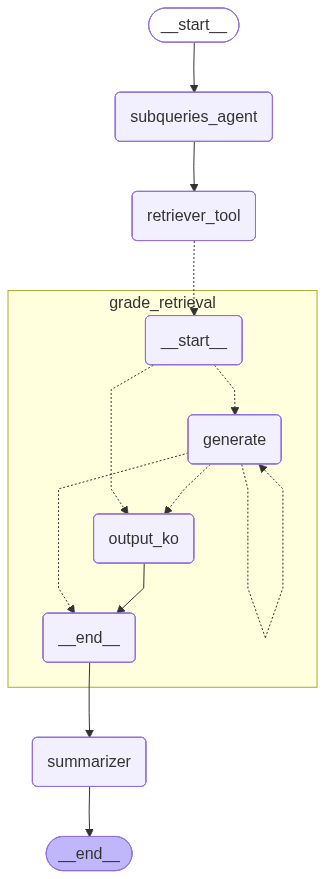

In [55]:
mdl_graph = StateGraph(
    state_schema= MdlState,
    input_schema= MdlState,
    output_schema= MdlOutputState
)

mdl_graph.add_node('subqueries_agent', generate_mdl_sub_queries)
mdl_graph.add_node('retriever_tool', retrieve_mdl_queries)
mdl_graph.add_node('grade_retrieval', grading_generation_graph)
mdl_graph.add_node('summarizer', summarize_mdl)

mdl_graph.add_edge(START, 'subqueries_agent')
mdl_graph.add_edge('subqueries_agent', 'retriever_tool')
mdl_graph.add_conditional_edges('retriever_tool', send_to_parallel_grade, ['grade_retrieval'])
mdl_graph.add_edge('grade_retrieval', 'summarizer')
mdl_graph.add_edge('summarizer', END)


mdl_graph = mdl_graph.compile()

display(Image(mdl_graph.get_graph(xray=1).draw_mermaid_png()))

In [72]:
user_query = 'The name of the product with highest sales.'

result = mdl_graph.invoke({
    "user_query": user_query,
    'language': 'English'
})

Markdown(result['data_schema'])

---MDL SUB-QUERIES---
---MDL RETRIEVE TOOL---


No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---GENERATE---


### Detailed Summary of Relevant Tables and Columns

#### Table: `dim_product`
- **Database**: `adventure_works_dw`
- **Schema**: `sales`
- **Description**: Dimension table storing detailed information about each product ever sold.
- **Primary Key**: `product_key`
- **Columns**:
  - `english_product_name` (VARCHAR(50)): Name of the product in English. **Cannot be NULL**.
  - `standard_cost` (NUMERIC): Standard cost of the product in USD.
  - `list_price` (NUMERIC): Sale price of the product in USD.

#### Table: `fact_sales`
- **Database**: `adventure_works_dw`
- **Schema**: `sales`
- **Description**: Contains detailed sales order information at the line level.
- **Primary Keys**: `sales_order_number`, `sales_order_line_number`
- **Foreign Keys**:
  - `product_key` → `sales.dim_product.product_key`
- **Columns**:
  - `order_quantity` (INT2): Quantity sold of each product.
  - `sales_amount` (NUMERIC): Subtotal in USD for the sales order line. **Cannot be NULL**.
  - `extended_amount` (NUMERIC): Total sales price in USD for all product units.
  - `unit_price` (NUMERIC): Sales price in USD per product unit.
  - `sale_source` (TEXT): Source of the order ('reseller_sales' or 'internet_sales').
  - `order_date` (DATE): Date the order was created.
  - `total_product_cost` (NUMERIC): Standard cost in USD for all product units.
  - `freight` (NUMERIC): Shipping cost in USD attributed to the sales order line.
  - `product_standard_cost` (NUMERIC): Standard cost in USD per product unit.
  - `unit_price_discount_pct` (FLOAT8): Discount percentage applied to the product unit price.
  - `ship_date` (DATE): Date the order was shipped to the customer.
  - `discount_amount` (FLOAT8): Total discount amount in USD.
  - `tax_amt` (NUMERIC): Tax amount in USD applicable to the sales order line.
  - `due_date` (DATE): Date the order was delivered to the customer.

### Table Relationships and SQL Join Conditions

- To determine the product with the highest sales:
  - Use the `fact_sales` table to calculate total sales for each product using the `sales_amount` column.
  - Join `fact_sales` with `dim_product` using the condition `fact_sales.product_key = dim_product.product_key`.
  - Retrieve the `english_product_name` column from `dim_product` for the product name.

### Grafo de Generación de Contexto

#### LLM's

##### Language Detection

##### DB Schema Extractor

In [57]:
class DbSchemaExtractionResult(BaseModel):
    """
    Structured output for extracting database and schema names.
    """
    db_name: str = Field(
        description= "The name of the database where the data is stored. If not found, set to '[Not found]'."
    )
    schema_name: str = Field(
        description= "The name of the schema within the database. If not found, set to '[Not found]'."
    )

structured_llm_extractor = llm_retrievals.with_structured_output(DbSchemaExtractionResult)

db_params_extractor_prompt = """
You are a highly efficient and accurate data extraction agent. 
Your task is to analyze a provided text summary of a data schema and extract \
two key pieces of information: the **database name** and the **schema name**.

---

### INSTRUCTIONS

1.  **Extract the database name:** Identify the name of the database.
2.  **Extract the schema name:** Identify the name of the schema.
3.  **Strict Rule:** Only extract names that are explicitly identified as \
    a database or a schema. Do not guess or infer from table names, columns, \
    or other data objects.
4.  **Handling "Not Found":** If you cannot find an explicit database name or \
    schema name in the text, you MUST set the corresponding field to the exact \
    string '[Not Found]'.

---

### INPUT

[CONTEXT]
<context>
{data_schema}
</context>

"""

extractor_prompt = ChatPromptTemplate.from_messages([
    ('system', db_params_extractor_prompt)
])

params_extractor = extractor_prompt | structured_llm_extractor

data_schema = """
### Resumen de Tablas y Columnas Relevantes

#### Tabla: `fact_sales`
- **Base de datos**: `adventure_works_dw`
- **Esquema**: `sales`
- **Descripción**: Contiene detalles de las órdenes de ventas entregadas, con granularidad a nivel de línea.
- **Llaves Primarias**: `sales_order_number`, `sales_order_line_number`
- **Llaves Foráneas**:
  - `product_key` → `sales.dim_product.product_key`
  - `reseller_key` → `sales.dim_reseller.reseller_key`
  - `employee_key` → `sales.dim_sales_person.employee_key`
  - `customer_key` → `sales.dim_customer.customer_key`
  - `promotion_key` → `sales.dim_promotion.promotion_key`
  - `sales_territory_key` → `sales.dim_sales_territory.sales_territory_key`
- **Columnas**:
  - `order_quantity` (INT2): Cantidad vendida de cada producto. Puede ser NULL.
  - `unit_price` (NUMERIC): Precio de venta en USD de cada unidad de producto. Puede ser NULL.
  - `extended_amount` (NUMERIC): Precio total en USD de todas las unidades de producto. Puede ser NULL.
  - `sale_source` (TEXT): Fuente del pedido. Puede ser NULL.
  - `order_date` (DATE): Fecha de creación del pedido. Puede ser NULL.
  - `freight` (NUMERIC): Coste de envío en USD. Puede ser NULL.
  - `ship_date` (DATE): Fecha de envío del pedido. Nunca es NULL.
  - `sales_amount` (NUMERIC): Subtotal en USD de la línea de orden de venta. Puede ser NULL.
  - `total_product_cost` (NUMERIC): Coste estándar en USD de todas las unidades de producto. Puede ser NULL.
  - `due_date` (DATE): Fecha de entrega del pedido. Nunca es NULL.
  - `unit_price_discount_pct` (FLOAT8): Porcentaje de descuento aplicado. Puede ser NULL.
  - `discount_amount` (FLOAT8): Importe total de descuento en USD. Puede ser NULL.
  - `tax_amt` (NUMERIC): Importe de impuestos en USD. Puede ser NULL.
  - `product_standard_cost` (NUMERIC): Coste estándar en USD de cada unidad de producto. Puede ser NULL.

#### Tabla: `dim_product`
- **Base de datos**: `adventure_works_dw`
- **Esquema**: `sales`
- **Descripción**: Información detallada de cada producto vendido.
- **Llave Primaria**: `product_key`
- **Columnas**:
  - `list_price` (NUMERIC): Precio de venta en USD. Puede ser NULL.
  - `active` (BOOL): Indicador de disponibilidad. Puede ser NULL.
  - `finished_goods_flag` (BOOL): Indicador de producto vendible. Puede ser NULL.
  - `spanish_product_category_name` (VARCHAR(50)): Categoría principal en español. Nunca es NULL.
  - `english_product_category_name` (VARCHAR(50)): Categoría principal en inglés. Nunca es NULL.
  - `style` (BPCHAR(2)): Público objetivo. Puede ser NULL.
  - `english_product_name` (VARCHAR(50)): Nombre del producto en inglés. Nunca es NULL.
  - `english_product_subcategory_name` (VARCHAR(50)): Subcategoría en inglés. Nunca es NULL.
  - `spanish_product_subcategory_name` (VARCHAR(50)): Subcategoría en español. Nunca es NULL.
  - `start_date` (DATE): Fecha de disponibilidad. Puede ser NULL.
  - `safety_stock_level` (INT2): Nivel de stock mínimo. Puede ser NULL.
  - `end_date` (DATE): Fecha de descontinuación. Puede ser NULL.
  - `size` (VARCHAR(50)): Talla del producto. Puede ser NULL.
  - `class` (BPCHAR(2)): Gama del producto. Puede ser NULL.
  - `spanish_product_name` (VARCHAR(50)): Nombre del producto en español. Puede ser NULL.

### Relación entre Tablas
- La tabla `fact_sales` se relaciona con `dim_product` mediante la columna `product_key`.
- Condición de unión sugerida: `fact_sales.product_key = dim_product.product_key`.
"""

# data_schema = 'Esto solo son tablas como dim_fact and fact_customer'
result = params_extractor.invoke({'data_schema': data_schema})
result

DbSchemaExtractionResult(db_name='adventure_works_dw', schema_name='sales')

In [58]:
print(f'{result.db_name=}')
print(f'{result.schema_name=}')

result.db_name='adventure_works_dw'
result.schema_name='sales'


In [59]:
class DefineLanguageResult(BaseModel):
    """Detect the language of the user query."""

    language: str = Field(
        description= "Language of user query in English, e.g. Spanish, English, etc."
    )

structured_llm_language_detector = llm_classifiers.with_structured_output(DefineLanguageResult)

language_system_prompt = """
Your goal is to identify the language of the user's query and respond with \
only the name of that language in English. Do not include any other text or punctuation.

### Example User Query:

"¿Qué hora es?"

### Your Expected Response:

Spanish
"""

language_prompt = ChatPromptTemplate.from_messages([
    ("system", language_system_prompt),
    ("human", "{user_query}")
])

language_detector = language_prompt | structured_llm_language_detector


print('Spanish user_query:')
spanish_user_query = '¿Cuál es el promedio de ventas por producto?'
print(f"'{spanish_user_query}'")
print(language_detector.invoke({"user_query": spanish_user_query}))

print('\n' + '-'*100 + '\n')

print('English user_query:')
english_user_query = 'Tell me the average value of sales by products.'
print(f"'{english_user_query}'")
print(language_detector.invoke({"user_query": english_user_query}))

Spanish user_query:
'¿Cuál es el promedio de ventas por producto?'
language='Spanish'

----------------------------------------------------------------------------------------------------

English user_query:
'Tell me the average value of sales by products.'
language='English'


##### Final Summarizer

In [60]:
class GlobalContextSummaryResult(BaseModel):
    """Relevant global summary generated from business logic and tables schemas based in user query."""
    generated_context: str = Field(
        description= "Global summary of business logic and tables schemas relevant for a data analyst SQL query confection."
    )

structured_llm_global_context_generator = llm_generation.with_structured_output(GlobalContextSummaryResult)


global_context_generator_system_prompt = """
You are a highly precise and diligent Ultimate Data & Business Synthesis Agent. \
Your sole purpose is to process and synthesize complex information from two distinct sources: \
a **Data Schema** (tables, columns, and relationships) and **Business Logic** (rules and concepts). \
Your goal is to produce a single, comprehensive, and detailed output that consolidates all \
provided information into a unified, business-oriented view.

The final output is intended for a data analyst who will use it to build a structured SQL query. \
The response must be clear, precise, and contain all the necessary details to represent \
the table structures, relationships, and business rules accurately.

---

### INSTRUCTIONS

1. Strictly Adhere to Context: Your response must be derived exclusively from the information \
    provided in the [DATA_SCHEMA] and [BUSINESS_LOGIC] sections. You MUST NOT invent, infer, or \
    hallucinate any details, tables, columns, rules, or logic that are not explicitly present in the provided context.

2. Handle Lack of Context: If a context extract explicitly states that no relevant information is available, \
    you must ignore that extract. If all provided context extracts state that no relevant information is available, \
    your final output must be a single, brief sentence stating that no relevant tables, columns, \
    or business logic were found for the user's query.

3. Ensure Full Coverage: Every single piece of relevant information from both the data schema and \
    the business logic context must be incorporated into your final output. Leave no detail unaddressed.

4. Language-Specific Prioritization & Synergy: You MUST prioritize providing all potentially relevant information \
    while ensuring it aligns with the user's query language defined in {language}. The guiding principle is to include \
    more data rather than risk omitting valuable details, but with an intelligent filter for language.

    - Data Schema: Include all tables and columns from the [DATA_SCHEMA] that have any potential relevance to the user's query.
    - Business Logic: Incorporate all business rules and concepts from the [BUSINESS_LOGIC] context.
    - Cross-Reference: You MUST ensure that any table or column from the [DATA_SCHEMA] that is explicitly named or \
        referenced within the [BUSINESS_LOGIC] context is included in your final output. \
        Highlight these connections to provide a clear, business-oriented view for the analyst.
    - Language-Specific Translation: If the context provides language-specific information \
        (e.g., column names, placeholder values, or SQL fragments) that do not match the {language} \
        of the user's query, \you MUST translate or adapt this information to the target language. \
        For example, if the query is in English and a rule mentions a placeholder "No registrado", \
        you should adapt it to a relevant English equivalent like "Not Registered". \
        Similarly, if a SQL fragment uses a Spanish alias, you must provide the English equivalent.

5. Column Details: For all relevant columns, include information regarding their data type, \
    nullability (e.g., NOT NULL), and any expected values or constraints explicitly mentioned in the context. \
    **Do not modify column names.** Only aliases may be adapted for clarity.

6. SQL Handling: You MUST INCLUDE any SQL fragments or clauses explicitly present in the [DATA_SCHEMA] and \
    [BUSINESS_LOGIC] contexts. You are **ABSOLUTELY FORBIDDEN** from inventing, extracting, or suggesting any \
    new SQL query or complete SQL code not provided in the source material. Only provide fragments or components \
    strictly derived from the context.

7. Time-Based Logic: If the user's query involves temporal filtering or aggregation (e.g., "last month," \
    "current quarter," "year-to-date" / "YTD"), you MUST provide a **representative SQL fragment** \
    for the WHERE clause or aggregation condition that applies the appropriate temporal logic. \
    These fragments must be strictly derived from any temporal information in the context; if none \
    is provided, \indicate the expected logic without inventing table or column names. This ensures the \
    analyst has a concrete example to implement the temporal filter.

8. No Full Queries: **Do not generate full or executable SQL queries**. Only include fragments or components derived from the context, possibly adjusted for clarity, without altering the underlying logic.

9. Language: The output MUST be a text in **{language}**.

10. Purpose-Oriented Output: The response must be clear, precise, and contain all the necessary details \
    to represent the table structure, relationships, and business rules accurately. Organize the information \
    logically using markdown headings, subheadings, and bullet points to facilitate easy understanding \
    and translation into a query structure.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[BUSINESS_LOGIC]
<business_logic>
{business_logic}
</business_logic>

[DATA_SCHEMA]
<data_schema>
{data_schema}
</data_schema>

---

### OUTPUT

Your final output should be a single, structured text with three main sections:
1. A brief, high-level summary of the business goal and the relevant data assets.
2. A detailed breakdown of all relevant tables, including the **database** \
    and **schema** they belong to, along with their columns and relationships.
3. A summary of the relevant business rules, including specific temporal \
    definitions or aggregations if they are present in the user's query.

Ensure every detail from both contexts is accounted for and explained in a logical flow. \
The output should empower the data analyst to construct the query without needing external information.
"""

global_context_prompt = ChatPromptTemplate.from_template(
    global_context_generator_system_prompt
)

global_context_generator = global_context_prompt | structured_llm_global_context_generator

user_query = 'The product most selled.'

business_logic = """
### Synthesized Business Logic

#### High-Level Summary
The query seeks to identify the product that has been sold the most, which can be measured by the quantity of units sold (`order_quantity`).

#### Detailed Breakdown

- **Metric Definition**:
  - The term "most sold" refers to the product with the highest quantity of units sold (`order_quantity`).
  - If the query specifies "highest revenue," the metric would shift to the total sales amount (`sales_amount`).

- **Entity Representation**:
  - For product representation, prioritize the `_name` fields, using Spanish names if available, and fallback to English names if not.
  - Example SQL for product name representation:
    ```sql
    SELECT
        product_key,
        COALESCE(spanish_product_name, english_product_name) AS producto_nombre
    FROM
        sales.dim_product;
    ```

- **Handling Null Values**:
  - For attributes like `product_line`, `class`, and `style`, replace null values with placeholders indicating "not registered" in the query's language.
  - Example SQL for handling null values:
    ```sql
    SELECT
        product_key,
        COALESCE(product_line, '|| No registrado ||') AS producto_linea
    FROM
        sales.dim_product;
    ```

This synthesized logic provides the necessary details to construct a SQL query to identify the most sold product based on the provided context.
"""

data_schema = """
### Detailed Summary of Relevant Tables and Columns

#### Table: `dim_product`
- **Database**: adventure_works_dw
- **Schema**: sales
- **Description**: Dimension table storing detailed information about each product ever sold. Relevant for queries listing products by name.
- **Primary Key**: `product_key`
- **Columns**:
  - `english_product_name` (VARCHAR(50)): Name of the product in English. This column is never NULL.
  - `dealer_price` (NUMERIC): Distributor price in USD. Nullability not specified.

#### Table: `fact_sales`
- **Database**: adventure_works_dw
- **Schema**: sales
- **Description**: Contains detailed sales order information at the line level, always showing the latest version of each order. It is the primary source for sales data such as quantities sold, sales amounts, costs, taxes, shipping costs, and more.
- **Primary Keys**: `sales_order_number`, `sales_order_line_number`
- **Foreign Keys**:
  - `product_key` → `sales.dim_product.product_key`
- **Columns**:
  - `sales_amount` (NUMERIC): Represents the subtotal in USD for the sales order line, calculated as `extended_amount - discount_amount`. Nullability not specified.
  - `product_key` (Foreign Key): Links to the product dimension table. Nullability not specified.

### Relationships and SQL Join Conditions
To determine the product with the highest sales amount:
1. Use the `fact_sales` table as the primary source.
2. Aggregate `sales_amount` grouped by `product_key`.
3. Join with the `dim_product` table using `fact_sales.product_key = dim_product.product_key` to retrieve the product name.
"""

# business_logic = "No relevant business logic to the user query."
# data_schema = "No relevant tables nor columns to the user query."

print(global_context_generator.invoke({
    "user_query": user_query,
    "language": 'Spanish',
    "business_logic": business_logic,
    "data_schema": data_schema
}).generated_context)

### Resumen de Alto Nivel
El objetivo de la consulta es identificar el producto más vendido, medido por la cantidad total de unidades vendidas (`order_quantity`).

### Detalle de Tablas Relevantes
#### Tabla: `dim_product`
- **Base de Datos**: adventure_works_dw
- **Esquema**: sales
- **Descripción**: Tabla de dimensión que almacena información detallada sobre cada producto vendido.
- **Clave Primaria**: `product_key`
- **Columnas**:
  - `english_product_name` (VARCHAR(50)): Nombre del producto en inglés. Nunca es NULL.
  - `dealer_price` (NUMERIC): Precio del distribuidor en USD. La posibilidad de NULL no está especificada.

#### Tabla: `fact_sales`
- **Base de Datos**: adventure_works_dw
- **Esquema**: sales
- **Descripción**: Contiene información detallada de las órdenes de venta a nivel de línea.
- **Claves Primarias**: `sales_order_number`, `sales_order_line_number`
- **Claves Foráneas**:
  - `product_key` → `sales.dim_product.product_key`
- **Columnas**:
  - `sales_amount` (NUMER

##### No Relevant Context Message Generator

In [61]:
class NoRelevantContextResult(BaseModel):
    """
    Generate a concise apology to the user when the AI's knowledge base lacks relevant information
    to answer the query. The message should include some example topics the AI can discuss.
    """

    no_context_message: str = Field(
        description= (
            "A polite and apologetic message to the user, explaining that the current "
            "knowledge base does not contain information on the topic. The message must "
            "also offer to answer questions on other topics based in the context bringed."
        )
    )

structured_llm_no_context_replier = llm_retrievals.with_structured_output(NoRelevantContextResult)

no_context_response_system_prompt = """
You are an AI assistant designed to respond to users when their queries cannot be \
answered due to a lack of relevant context. Your sole task is to generate a polite \
apology and offer to help with other topics that are within your knowledge domain.

---

### INSTRUCTIONS

1.  **Core Task:** Your only job is to generate a response. \
    Do not try to answer the original user query.

2.  **Apology:** Start with a polite apology, clearly stating that \
    you cannot answer the user's question.

3.  **Reason:** Explain that the topic is outside the scope \
    of your current knowledge base.

4.  **Offer of Help:** Based on the provided context, offer \
    to answer questions that are relevant to the data warehouse.

5.  **Examples:** Include 2 or 3 specific examples of topics you can answer, \
    pulling directly from the concepts mentioned in the context. \
    For instance, if the context mentions "sales data" or "product inventory," \
    use these as examples.

6.  **Language:** The output MUST be a text in **{language}**.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[CONTEXT]
<context>
{context}
</context>
"""

no_context_prompt = ChatPromptTemplate.from_template(no_context_response_system_prompt)

no_context_replier = no_context_prompt | structured_llm_no_context_replier


user_query = '¿Cuál es el departamento con salario medio más elevado?'

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

print('User Query:')
print(f"'{user_query}'", end='\n\n')
print('Context:')
print(doc_txt, end='\n\n')
print(no_context_replier.invoke({
    "user_query": user_query,
    "language": 'Spanish',
    "context": doc_txt,
}).no_context_message)

User Query:
'¿Cuál es el departamento con salario medio más elevado?'

Context:

3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la m

#### Estado

In [62]:
class ContextGeneratorState(TypedDict):
    user_query: str
    language: str
    business_logic: str
    data_schema: str
    db_name: str
    schema_name: str
    relevant_context: bool
    context: str
    context_retrieved_summary: str
    no_relevant_context_msg: str
    mdl_retrieval_results: List[Dict[str, str]]
    business_logic_retrieval_results: List[str]

class ContextGeneratorOutputState(TypedDict):
    language: str
    relevant_context: bool
    db_name: str
    schema_name: str
    context: str
    no_relevant_context_msg: str


#### Nodos

In [63]:
def detect_user_query_language(state: ContextGeneratorState):
    """
    Define the language of the user query.

    Args:
        state (dict): The current graph state
    """
    print("---DEFINE LANGUAGE---")
    user_query = state['user_query']
    
    language = language_detector.invoke({
            'user_query': user_query
    }).language

    return {
        'language': language,
    }


def extract_db_schema(state: MdlState):
    """
    Extracts the database and schema names from the summarized schema text.

    Args:
        state (dict): The current graph state.
    """
    print("---DB/SCHEMA EXTRACTION---")
    
    data_schema = state['data_schema']
    
    db_schema_params = params_extractor.invoke({
        'data_schema': data_schema
    })

    return {
        'db_name': db_schema_params.db_name,
        'schema_name': db_schema_params.schema_name,
    }


def generate_global_context(state: ContextGeneratorState):
    """
    Generate a global context based on Business Logic and Data Schema results.

    Args:
        state (dict): The current graph state
    """
    print("---GLOBAL CONTEXT GENERATION---")
    
    user_query = state['user_query']
    language = state['language']
    business_logic = state['business_logic']
    data_schema = state['data_schema']

    context = global_context_generator.invoke({
        "user_query": user_query,
        "language": language,
        "business_logic": business_logic,
        "data_schema": data_schema
    }).generated_context

    return {
        'context': context
    }


def grade_context_summaries(state: ContextGeneratorState):
    """
    Determines whether the generation is grounded in the 
    document and informative for question.

    Args:
        state (dict): The current graph state
    """
    print("---GRADING CONTEXT SUMMARIES---")
    
    user_query = state['user_query']
    business_logic_retrieval_results = state['business_logic_retrieval_results']
    mdl_retrieval_results = state['mdl_retrieval_results']

    context_list = ['### Business Logic Context']
    context_list.extend([business_logic_txt for business_logic_txt in business_logic_retrieval_results])
    context_list.append('### Tables Context')
    context_list.extend([
        '\n'.join(table['table_summary'].split('\n')[2:])
        for table in mdl_retrieval_results
    ])

    context_retrieved_summary = '\n\n---\n\n'.join(context_list)

    relevant_context = retrieval_grader.invoke({
        'user_query': user_query,
        'context': context_retrieved_summary
    }).relevant

    return {
        'context_retrieved_summary': context_retrieved_summary,
        'relevant_context': relevant_context,
    }


def generate_no_context_response(state: ContextGeneratorState):
    """
    When do not exist any relevant context, generate an 
    explanation for the user with examples.

    Args:
        state (dict): The current graph state
    """
    print("---NO RELEVANT CONTEXT RESPONSE GENERATION---")
    
    user_query = state['user_query']
    language = state['language']
    context_retrieved_summary = state['context_retrieved_summary']

    no_relevant_context_msg = no_context_replier.invoke({
        "user_query": user_query,
        "language": language,
        "context": context_retrieved_summary,
    }).no_context_message

    return {
        'no_relevant_context_msg': no_relevant_context_msg
    }

#### Conditional Edges

In [64]:
def route_context_relevance(state: ContextGeneratorState) -> Literal['get_global_context', 'get_no_relevance_response']:
    """
    Route the flow between generate the global context, or generate the no relevant context reply.

    Args:
        state (dict): The current graph state

    Results:
        The next step alias.
    """
    return (
        'get_global_context'
        if state['relevant_context'] else
        'get_no_relevance_response'
    )

#### Grafo

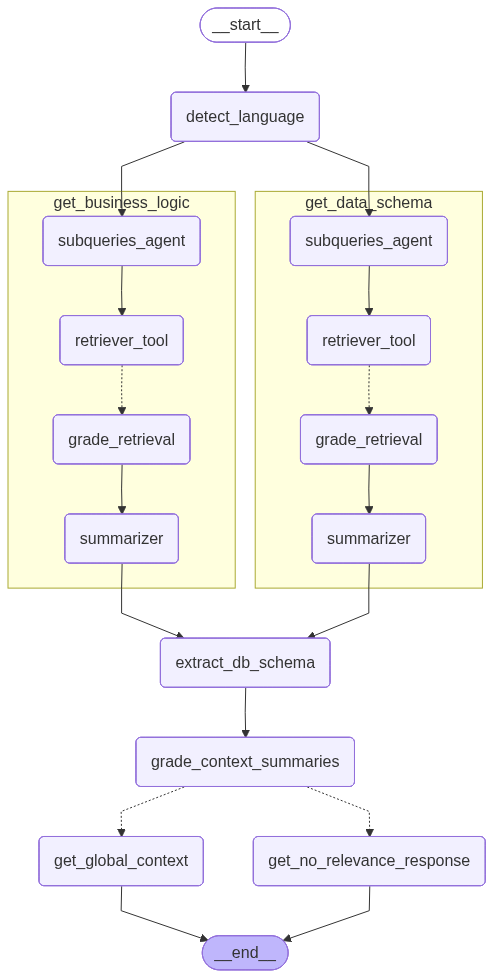

In [65]:
context_generation_graph = StateGraph(
    state_schema= ContextGeneratorState,
    input_schema= ContextGeneratorState,
    output_schema= ContextGeneratorOutputState
)

context_generation_graph.add_node('detect_language', detect_user_query_language)
context_generation_graph.add_node('get_business_logic', business_logic_graph)
context_generation_graph.add_node('get_data_schema', mdl_graph)
context_generation_graph.add_node('extract_db_schema', extract_db_schema)
context_generation_graph.add_node('grade_context_summaries', grade_context_summaries)
context_generation_graph.add_node('get_global_context', generate_global_context)
context_generation_graph.add_node('get_no_relevance_response', generate_no_context_response)

context_generation_graph.add_edge(START, 'detect_language')
context_generation_graph.add_edge('detect_language', 'get_business_logic')
context_generation_graph.add_edge('detect_language', 'get_data_schema')
context_generation_graph.add_edge('get_business_logic', 'extract_db_schema')
context_generation_graph.add_edge('get_data_schema', 'extract_db_schema')
context_generation_graph.add_edge('extract_db_schema', 'grade_context_summaries')
context_generation_graph.add_conditional_edges('grade_context_summaries', route_context_relevance)
context_generation_graph.add_edge('get_global_context', END)
context_generation_graph.add_edge('get_no_relevance_response', END)


context_generation_graph = context_generation_graph.compile()

display(Image(context_generation_graph.get_graph(xray=1).draw_mermaid_png()))

In [66]:
user_query = 'Dime las ventas del último trimestre detallas por categorías de producto.'

global_context_test = context_generation_graph.invoke({
    "user_query": user_query
})

global_context_test

---DEFINE LANGUAGE---
---BUSINESS LOGIC SUB-QUERIES---
---MDL SUB-QUERIES---
---BUSINESS LOGIC RETRIEVE TOOL---
---MDL RETRIEVE TOOL---


No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
--

No relevant docs were retrieved using the relevance score threshold 0.75


---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


No relevant docs were retrieved using the relevance score threshold 0.75


---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION ADDRESSES QUESTION---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION ADDRESSES QUESTION---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---


No relevant docs were retrieved using the relevance score threshold 0.75


---DECISION: GENERATION ADDRESSES QUESTION---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---BUSINES LOGIC SUMMARIZING---


No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GE

{'language': 'Spanish',
 'relevant_context': True,
 'db_name': 'adventure_works_dw',
 'schema_name': 'sales',
 'context': "### Resumen de la Meta de Negocio y Activos de Datos\n\nEl objetivo es obtener las ventas del último trimestre detalladas por categorías de producto. Para ello, se utilizarán las tablas `fact_sales` y `dim_product` del esquema `sales` en la base de datos `adventure_works_dw`.\n\n### Detalle de Tablas Relevantes\n\n#### Tabla: `fact_sales`\n- **Descripción:** Contiene detalles de órdenes de ventas con granularidad a nivel de línea.\n- **Claves Primarias:** `sales_order_number`, `sales_order_line_number`\n- **Columnas:**\n  - `order_quantity`: Cantidad vendida.\n  - `sales_amount`: Subtotal en USD.\n  - `order_date`: Fecha de creación del pedido.\n  - `product_standard_cost`: Coste estándar en USD.\n  - `tax_amt`: Importe de impuestos en USD.\n  - `discount_amount`: Importe de descuento en USD.\n  - `sale_source`: Fuente del pedido. Nunca viene a NULL.\n\n#### Tabla:

In [67]:
print(f"{global_context_test['db_name']=}")
print(f"{global_context_test['schema_name']=}")
Markdown(global_context_test['context'])

global_context_test['db_name']='adventure_works_dw'
global_context_test['schema_name']='sales'


### Resumen de la Meta de Negocio y Activos de Datos

El objetivo es obtener las ventas del último trimestre detalladas por categorías de producto. Para ello, se utilizarán las tablas `fact_sales` y `dim_product` del esquema `sales` en la base de datos `adventure_works_dw`.

### Detalle de Tablas Relevantes

#### Tabla: `fact_sales`
- **Descripción:** Contiene detalles de órdenes de ventas con granularidad a nivel de línea.
- **Claves Primarias:** `sales_order_number`, `sales_order_line_number`
- **Columnas:**
  - `order_quantity`: Cantidad vendida.
  - `sales_amount`: Subtotal en USD.
  - `order_date`: Fecha de creación del pedido.
  - `product_standard_cost`: Coste estándar en USD.
  - `tax_amt`: Importe de impuestos en USD.
  - `discount_amount`: Importe de descuento en USD.
  - `sale_source`: Fuente del pedido. Nunca viene a NULL.

#### Tabla: `dim_product`
- **Descripción:** Contiene información detallada de productos vendidos.
- **Clave Primaria:** `product_key`
- **Columnas:**
  - `spanish_product_category_name`: Categoría principal del producto (ESPAÑOL). Nunca viene a NULL.
  - `spanish_product_subcategory_name`: Subcategoría del producto (ESPAÑOL). Nunca viene a NULL.
  - `list_price`: Precio de venta en USD.
  - `start_date`: Fecha de inicio de disponibilidad del producto.
  - `end_date`: Fecha de fin de disponibilidad del producto. Puede ser NULL.

#### Relación entre Tablas
- **Condición de Unión:** `fact_sales.product_key = dim_product.product_key`

### Reglas de Negocio Relevantes

#### Definición de Trimestre
- Un trimestre es un período de tres meses.
- Los trimestres en un año natural son:
  - Q1: Enero a Marzo.
  - Q2: Abril a Junio.
  - Q3: Julio a Septiembre.
  - Q4: Octubre a Diciembre.

#### Filtrado Temporal
Para obtener las ventas del trimestre pasado:
```sql
WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';
```

#### Detalle por Categorías
Para detallar las ventas por categorías de producto, se puede incluir el campo `product_key` en la consulta y agrupar los resultados por `spanish_product_category_name`.

### Ejemplo de Consulta SQL
Para obtener las ventas del último trimestre detalladas por categorías de producto:
```sql
SELECT spanish_product_category_name, SUM(sales_amount) AS total_sales
FROM sales.fact_sales
JOIN sales.dim_product ON fact_sales.product_key = dim_product.product_key
WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day'
GROUP BY spanish_product_category_name;
```

In [68]:
user_query = 'Dime los 10 clientes que más han comprado el mes pasado.'

global_context_test = context_generation_graph.invoke({
    "user_query": user_query
})

global_context_test

---DEFINE LANGUAGE---
---BUSINESS LOGIC SUB-QUERIES---
---MDL SUB-QUERIES---
---MDL RETRIEVE TOOL---
---BUSINESS LOGIC RETRIEVE TOOL---


No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO-

No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75


---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


No relevant docs were retrieved using the relevance score threshold 0.75


---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---
---BUSINES LOGIC SUMMARIZING---


No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT------GRADE: DOCUMENT RELEVANT---
---GENERATE---

---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT------GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---

---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GE

{'language': 'Spanish',
 'relevant_context': True,
 'db_name': 'adventure_works_dw',
 'schema_name': 'sales',
 'context': '### Resumen de la Meta de Negocio y Activos de Datos\n\nLa consulta busca identificar los 10 clientes que más han comprado el mes pasado, utilizando datos de ventas y clientes en el contexto de ventas en línea (B2C).\n\n### Detalle de Tablas Relevantes\n\n#### Base de Datos: adventure_works_dw\n#### Esquema: sales\n\n##### Tabla: dim_customer\n- **Descripción:** Contiene información detallada de clientes.\n- **Columnas:**\n  - `customer_key`: Clave primaria.\n  - `customer_full_name`: Nombre completo del cliente (TEXT, puede ser NULL).\n\n##### Tabla: fact_sales\n- **Descripción:** Detalle de órdenes de ventas.\n- **Columnas:**\n  - `customer_key`: Clave foránea hacia `dim_customer`.\n  - `sales_amount`: Subtotal de la línea de orden de venta (NUMERIC, puede ser NULL).\n  - `order_date`: Fecha de creación del pedido (DATE, puede ser NULL).\n\n### Reglas de Negocio 

In [69]:
print(f"{global_context_test['db_name']=}")
print(f"{global_context_test['schema_name']=}")
Markdown(global_context_test['context'])

global_context_test['db_name']='adventure_works_dw'
global_context_test['schema_name']='sales'


### Resumen de la Meta de Negocio y Activos de Datos

La consulta busca identificar los 10 clientes que más han comprado el mes pasado, utilizando datos de ventas y clientes en el contexto de ventas en línea (B2C).

### Detalle de Tablas Relevantes

#### Base de Datos: adventure_works_dw
#### Esquema: sales

##### Tabla: dim_customer
- **Descripción:** Contiene información detallada de clientes.
- **Columnas:**
  - `customer_key`: Clave primaria.
  - `customer_full_name`: Nombre completo del cliente (TEXT, puede ser NULL).

##### Tabla: fact_sales
- **Descripción:** Detalle de órdenes de ventas.
- **Columnas:**
  - `customer_key`: Clave foránea hacia `dim_customer`.
  - `sales_amount`: Subtotal de la línea de orden de venta (NUMERIC, puede ser NULL).
  - `order_date`: Fecha de creación del pedido (DATE, puede ser NULL).

### Reglas de Negocio Relevantes

1. **Cálculo del Volumen de Ventas por Cliente:**
   - Agregar `sales_amount` agrupado por `customer_key`.
2. **Filtro Temporal:**
   - Limitar las ventas al mes pasado utilizando `order_date`.
3. **Ordenación y Selección:**
   - Ordenar por el total de ventas en orden descendente y seleccionar los 10 primeros.

### Fragmento SQL Representativo

```sql
SELECT
    fs.customer_key,
    dc.customer_full_name AS cliente,
    SUM(fs.sales_amount) AS importe_ventas_por_cliente
FROM sales.fact_sales fs
JOIN sales.dim_customer dc ON fs.customer_key = dc.customer_key
WHERE fs.order_date >= DATEADD(MONTH, -1, GETDATE()) AND fs.order_date < GETDATE()
GROUP BY fs.customer_key, dc.customer_full_name
ORDER BY importe_ventas_por_cliente DESC
LIMIT 10;
```

In [70]:
user_query = 'Dime el departamento con el salario medio más alto.'

global_context_test = context_generation_graph.invoke({
    "user_query": user_query
})

global_context_test

---DEFINE LANGUAGE---
---BUSINESS LOGIC SUB-QUERIES---
---MDL SUB-QUERIES---
---MDL RETRIEVE TOOL---
---BUSINESS LOGIC RETRIEVE TOOL---
---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---


No relevant docs were retrieved using the relevance score threshold 0.75


---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---BUSINES LOGIC SUMMARIZING---


No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT------GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---

---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---MDL SUMMARIZING---
---DB/SCHEMA 

{'language': 'Spanish',
 'relevant_context': False,
 'db_name': '[Not Found]',
 'schema_name': '[Not Found]',
 'no_relevant_context_msg': 'Lo siento, pero no puedo responder a tu pregunta sobre el departamento con el salario medio más alto, ya que este tema está fuera del alcance de mi base de conocimientos actual. Sin embargo, puedo ayudarte con otros temas relacionados con ventas, como el volumen de ventas por agente comercial o el valor promedio por orden. ¿Te gustaría saber más sobre alguno de estos temas?'}

In [71]:
print(f"{global_context_test['db_name']=}")
print(f"{global_context_test['schema_name']=}")
Markdown(global_context_test['no_relevant_context_msg'])

global_context_test['db_name']='[Not Found]'
global_context_test['schema_name']='[Not Found]'


Lo siento, pero no puedo responder a tu pregunta sobre el departamento con el salario medio más alto, ya que este tema está fuera del alcance de mi base de conocimientos actual. Sin embargo, puedo ayudarte con otros temas relacionados con ventas, como el volumen de ventas por agente comercial o el valor promedio por orden. ¿Te gustaría saber más sobre alguno de estos temas?